# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.995 #0.8 #0.9891 # 1-(60/5*24)/50977

#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = False # False

EPOCHS_AE = 500#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_4787/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
87833  1698881100000   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834  1698881400000   1846.39   1846.89  1844.37    1845.32    828.6682   
87835  1698881700000   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836  1698882000000   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837  1698882300000   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00       1842.800000       1826.145000   
87834  2023-11-01 23:30:00       1842.812500       1826.145000   
87835  2023-11-01 23:35:00       1844.047500       1826.145000   
87836  2023-11-01 23:40:00       1844.752500       1826.145000   
87837  2023-11-01 23:45:00       1845.090000       1826.145000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
87833         1847.06  ...   NaN         NaN            NaN           NaN   
87834         1847.06  ...   NaN         NaN            NaN           NaN   
87835         1847.06  ...   NaN         NaN            NaN           NaN   
87836         1847.06  ...   NaN         NaN            NaN           NaN   
87837         1847.06  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87833               NaN         0.0               NaN         0.0      0.0   
87834               NaN         0.0               NaN         0.0      0.0   
87835               NaN         0.0               NaN         0.0      0.0   
87836               NaN         0.0               NaN         0.0      0.0   
87837               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
87833   NaN  
87834   NaN  
87835   NaN  
87836   NaN  
87837   NaN  

[87838 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH        1
vwap_z_score_BTC        1
ichi_tenkan_ETH         8
ichi_tenkan_BTC         8
rsi_h_ETH              13
                    ...  
Actual              87801
Event               87801
Country             87801
keep                87801
date                87801
Length: 65, dtype: int64

on 87838 samples


#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
87833  1698881100000   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834  1698881400000   1846.39   1846.89  1844.37    1845.32    828.6682   
87835  1698881700000   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836  1698882000000   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837  1698882300000   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00       1842.800000       1826.145000   
87834  2023-11-01 23:30:00       1842.812500       1826.145000   
87835  2023-11-01 23:35:00       1844.047500       1826.145000   
87836  2023-11-01 23:40:00       1844.752500       1826.145000   
87837  2023-11-01 23:45:00       1845.090000       1826.145000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...   1.0         0.0            0.0           0.0   
1             1194.71  ...   1.0         0.0            0.0           0.0   
2             1194.71  ...   1.0         0.0            0.0           0.0   
3             1194.71  ...   1.0         0.0            0.0           0.0   
4             1194.71  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
87833         1847.06  ...   NaN         NaN            NaN           NaN   
87834         1847.06  ...   NaN         NaN            NaN           NaN   
87835         1847.06  ...   NaN         NaN            NaN           NaN   
87836         1847.06  ...   NaN         NaN            NaN           NaN   
87837         1847.06  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87833               NaN         0.0               NaN         0.0      0.0   
87834               NaN         0.0               NaN         0.0      0.0   
87835               NaN         0.0               NaN         0.0      0.0   
87836               NaN         0.0               NaN         0.0      0.0   
87837               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
87833                  NaN  
87834                  NaN  
87835                  NaN  
87836                  NaN  
87837                  NaN  

[87838 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       57
delta_event_real    57
delta_event_pred    57
Previous_num        57
Actual_num          57
Event               57
Date                57
Previous            57
Consensus           57
Actual              57
Country             57
Time (ET)           57
keep                57
date                57
dtype: int64

on 87838 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
87833   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834   1846.39   1846.89  1844.37    1845.32    828.6682   
87835   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00       1842.800000       1826.145000   
87834  2023-11-01 23:30:00       1842.812500       1826.145000   
87835  2023-11-01 23:35:00       1844.047500       1826.145000   
87836  2023-11-01 23:40:00       1844.752500       1826.145000   
87837  2023-11-01 23:45:00       1845.090000       1826.145000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0             1194.71         1194.710  ...  1196.096667  1196.096667   
1             1194.71         1194.710  ...  1195.801420  1195.801420   
2             1194.71         1194.710  ...  1195.648641  1195.648641   
3             1194.71         1194.710  ...  1195.575250  1195.575250   
4             1194.71         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
87833         1847.06         1844.515  ...  1720.543655  1660.473980   
87834         1847.06         1844.515  ...  1720.566001  1660.486846   
87835         1847.06         1844.515  ...  1720.597513  1660.506866   
87836         1847.06         1844.515  ...  1720.622873  1660.522111   
87837         1847.06         1845.685  ...  1720.629931  1660.524945   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
87833  1701.257288  1681.743021   1721.563508          0.766061  0.067606   
87834  1701.259782  1681.754601   1721.564415          0.759491  0.067065   
87835  1701.262865  1681.773980   1721.565760          0.744633  0.065839   
87836  1701.262844  1681.786444   1721.566854          0.756534  0.066821   
87837  1701.260573  1681.784360   1721.566991          0.758622  0.066992   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.204923e+08      451884.0       17.665791  
1      1.204923e+08      451884.0       17.665791  
2      1.204923e+08      451884.0       17.665791  
3      1.204923e+08      451884.0       17.665791  
4      1.204923e+08      451884.0       17.665791  
...             ...           ...             ...  
87833  1.202693e+08      443638.0       16.512727  
87834  1.202693e+08      443638.0       16.512727  
87835  1.202693e+08      443638.0       16.512727  
87836  1.202693e+08      443638.0       16.512727  
87837  1.202693e+08      443638.0       16.512727  

[87838 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
87833  4.705  4237.859863  106.630997
87834  4.705  4237.859863  106.630997
87835  4.705  4237.859863  106.630997
87836  4.705  4237.859863  106.630997
87837  4.705  4237.859863  106.630997

[87838 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

87838

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

87399

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
87833  1698881100000   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834  1698881400000   1846.39   1846.89  1844.37    1845.32    828.6682   
87835  1698881700000   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836  1698882000000   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837  1698882300000   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00       1842.800000       1826.145000   
87834  2023-11-01 23:30:00       1842.812500       1826.145000   
87835  2023-11-01 23:35:00       1844.047500       1826.145000   
87836  2023-11-01 23:40:00       1844.752500       1826.145000   
87837  2023-11-01 23:45:00       1845.090000       1826.145000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
87833         1847.06  ...         NaN            NaN           NaN   
87834         1847.06  ...         NaN            NaN           NaN   
87835         1847.06  ...         NaN            NaN           NaN   
87836         1847.06  ...         NaN            NaN           NaN   
87837         1847.06  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87833               NaN         0.0               NaN         0.0      0.0   
87834               NaN         0.0               NaN         0.0      0.0   
87835               NaN         0.0               NaN         0.0      0.0   
87836               NaN         0.0               NaN         0.0      0.0   
87837               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
87833                  NaN  False  
87834                  NaN  False  
87835                  NaN  False  
87836                  NaN  False  
87837                  NaN  False  

[87838 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
87395  1698749700000   1802.82   1803.21  1801.19    1801.47    617.4601   
87396  1698750000000   1801.46   1803.14  1801.17    1803.13   1029.6104   
87397  1698750300000   1803.13   1803.49  1801.40    1801.52    452.7366   
87398  1698750600000   1801.51   1802.40  1800.41    1801.50    748.0749   
87399  1698750900000   1801.50   1803.12  1800.64    1802.25    421.8161   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87395  2023-10-31 10:55:00       1791.920000       1792.910000   
87396  2023-10-31 11:00:00       1793.422500       1792.910000   
87397  2023-10-31 11:05:00       1794.652500       1792.910000   
87398  2023-10-31 11:10:00       1794.910000       1792.910000   
87399  2023-10-31 11:15:00       1795.027500       1792.910000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
87395        1800.405  ...         5.5            5.5           5.5   
87396        1800.405  ...         5.5            5.5           5.5   
87397        1800.405  ...         5.5            5.5           5.5   
87398        1800.405  ...         5.5            5.5           5.5   
87399        1800.405  ...         5.5            5.5           5.5   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87395               0.0         0.0               0.0         0.0      0.0   
87396               0.0         0.0               0.0         0.0      0.0   
87397               0.0         0.0               0.0         0.0      0.0   
87398               0.0         0.0               0.0         0.0      0.0   
87399               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
87395  2023-11-01 19:00:00   True  
87396  2023-11-01 19:00:00   True  
87397  2023-11-01 19:00:00   True  
87398  2023-11-01 19:00:00   True  
87399  2023-11-01 19:00:00   True  

[87400 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
87400  1698751200000   1802.25   1802.25  1800.14    1801.54    546.2084   
87401  1698751500000   1801.54   1802.76  1801.54    1802.75    423.7807   
87402  1698751800000   1802.75   1808.38  1802.75    1807.46   1410.4577   
87403  1698752100000   1807.47   1812.68  1805.93    1805.93   3358.3953   
87404  1698752400000   1805.94   1809.53  1805.93    1807.69    658.2487   
...              ...       ...       ...      ...        ...         ...   
87833  1698881100000   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834  1698881400000   1846.39   1846.89  1844.37    1845.32    828.6682   
87835  1698881700000   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836  1698882000000   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837  1698882300000   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
87400  2023-10-31 11:20:00         1795.6375          1792.910   
87401  2023-10-31 11:25:00         1795.6375          1792.910   
87402  2023-10-31 11:30:00         1795.6375          1792.910   
87403  2023-10-31 11:35:00         1795.8100          1792.910   
87404  2023-10-31 11:40:00         1795.7975          1792.910   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00         1842.8000          1826.145   
87834  2023-11-01 23:30:00         1842.8125          1826.145   
87835  2023-11-01 23:35:00         1844.0475          1826.145   
87836  2023-11-01 23:40:00         1844.7525          1826.145   
87837  2023-11-01 23:45:00         1845.0900          1826.145   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
87400        1800.405  ...         5.5            5.5           5.5   
87401        1800.405  ...         5.5            5.5           5.5   
87402        1802.465  ...         5.5            5.5           5.5   
87403        1805.515  ...         5.5            5.5           5.5   
87404        1805.800  ...         5.5            5.5           5.5   
...               ...  ...         ...            ...           ...   
87833        1847.060  ...         NaN            NaN           NaN   
87834        1847.060  ...         NaN            NaN           NaN   
87835        1847.060  ...         NaN            NaN           NaN   
87836        1847.060  ...         NaN            NaN           NaN   
87837        1847.060  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
87400               0.0         0.0               0.0         0.0      0.0   
87401               0.0         0.0               0.0         0.0      0.0   
87402               0.0         0.0               0.0         0.0      0.0   
87403               0.0         0.0               0.0         0.0      0.0   
87404               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87833               NaN         0.0               NaN         0.0      0.0   
87834               NaN         0.0               NaN         0.0      0.0   
87835               NaN         0.0               NaN         0.0      0.0   
87836               NaN         0.0               NaN         0.0      0.0   
87837               NaN         0.0               NaN         0.0      0.0   

                      date  train  
87400  2023-11-01 19:00:00  False  
87401  2023-11-01 19:00:00  False  
87402  2023-11-01 19:00:00  False  
87403  2023-11-01 19:00:00  False  
87404  2023-11-01 19:00:00  False  
...                    ...    ...  
87833                  NaN  False  
87834                  NaN  False  
87835                  NaN  False  
87836                  NaN  False  
87837                  NaN  False  

[438 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(87313, 72, 102) (87313, 15)
(351, 72, 102) (351, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00058254, 0.9990513 , 0.99875171, 0.99833561, 0.99954507,
       0.99904575, 0.99988904, 1.000405  , 1.        , 1.00021082,
       1.00019418, 0.99945075, 1.00037171, 0.99947849, 0.99946739])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00108259, 1.00068287, 1.0012658 , ..., 1.00087718, 1.00013324,
        1.00105483],
       [0.99960071, 1.00018301, 0.99865238, ..., 0.99905168, 0.99997227,
        0.9990794 ],
       [1.00058254, 0.9990513 , 0.99875171, ..., 1.00037171, 0.99947849,
        0.99946739]])

In [39]:
seq_y

array([1.00058254, 0.9990513 , 0.99875171, 0.99833561, 0.99954507,
       0.99904575, 0.99988904, 1.000405  , 1.        , 1.00021082,
       1.00019418, 0.99945075, 1.00037171, 0.99947849, 0.99946739])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00108259, 1.00068287, 1.0012658 , ..., 1.00087718, 1.00013324,
        1.00105483],
       [0.99960071, 1.00018301, 0.99865238, ..., 0.99905168, 0.99997227,
        0.9990794 ],
       [1.00058254, 0.9990513 , 0.99875171, ..., 1.00037171, 0.99947849,
        0.99946739]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(87313, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(87313, 72, 102) (87313, 15)
(351, 72, 102) (351, 15)


## Standardization

In [44]:
path_scaler

'data/scaler.bin'

In [45]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [46]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00108259, 1.00068287, 1.0012658 , ..., 1.00087718, 1.00013324,
        1.00105483],
       [0.99960071, 1.00018301, 0.99865238, ..., 0.99905168, 0.99997227,
        0.9990794 ],
       [1.00058254, 0.9990513 , 0.99875171, ..., 1.00037171, 0.99947849,
        0.99946739]])

In [47]:
np.mean(y_train_sca)

6.958634701058417e-05

In [48]:
np.std(y_train_sca)

0.9998533350828614

In [49]:
np.mean(y_test_sca)

0.13003387595322338

In [50]:
np.std(y_test_sca)

0.9519263601857271

### Check unscaling

In [51]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1727.214729       1726.792302   
1    1195.38   1196.31   1196.69  1194.90       1727.214729       1726.792302   
2    1194.55   1195.38   1195.81  1194.55       1727.214729       1726.792302   
3    1195.98   1194.55   1195.98  1194.31       1727.214729       1726.792302   
4    1196.06   1195.98   1196.37  1195.97       1727.214729       1726.792302   
5    1196.61   1196.06   1196.70  1196.06       1727.214729       1726.792302   
6    1194.36   1196.62   1196.62  1193.72       1727.214729       1726.792302   
7    1194.22   1194.37   1194.43  1192.72       1727.214729       1726.792302   
8    1193.64   1194.22   1194.22  1193.02       1727.214729       1726.792302   
9    1194.64   1193.64   1195.06  1193.63       1727.214729       1726.792302   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1729.294931   
1         1194.71          1194.71           1729.294931   
2         1194.71          1194.71           1729.294931   
3         1194.71          1194.71           1729.294931   
4         1194.71          1194.71           1729.294931   
5         1194.71          1194.71           1729.294931   
6         1194.71          1194.71           1729.294931   
7         1194.71          1194.71           1729.294931   
8         1194.71          1194.71           1729.294931   
9         1194.71          1194.71           1729.294931   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
1           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
2           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
3           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
4           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
5           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
6           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
7           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
8           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   
9           1722.755644  ...  1.204923e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [52]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [53]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [54]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [55]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Check Inputs TRAIN/TEST 

In [56]:
X_train.reshape(-1, X_train.shape[-1]).shape

(6286536, 102)

In [57]:
X_train[:,-1,:].shape

(87313, 102)

In [58]:
X_test[:,-1,:].shape

(351, 102)

In [59]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.016198 -0.009653 -0.062063  0.082739         -0.042610   
1       0.016198 -0.037706 -0.074197  0.054600         -0.075914   
2       0.016198  0.026444 -0.051960  0.090793         -0.069434   
3       0.016198  0.108713  0.017852  0.097822          0.000286   
4       0.016198 -0.063781 -0.072175  0.029452         -0.042049   
...          ...       ...       ...       ...               ...   
87659   0.016198 -0.167328 -0.075207 -0.138658         -0.956876   
87660   0.016198 -0.264365 -0.060889 -0.274687         -1.094397   
87661   0.016198  0.004803 -0.004273 -0.202142         -1.057738   
87662   0.016198  0.248574  0.218208 -0.136585         -0.788264   
87663   0.016198  0.140708  0.055987 -0.002433         -0.693447   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.018015       -0.146391        -0.037721   
1             -0.019550       -0.177826        -0.070803   
2             -0.013405       -0.163258        -0.036214   
3              0.048776       -0.077718         0.053758   
4             -0.005894       -0.152925        -0.025345   
...                 ...             ...              ...   
87659         -1.396526       -0.255046        -0.434427   
87660         -1.584539       -0.478243        -0.564785   
87661         -1.592300       -0.489099        -0.542771   
87662         -1.266647       -0.272804        -0.315585   
87663         -1.179531       -0.157065        -0.194018   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  8.748914              8.119396  ...  0.365948  1.365963   
1                  8.735903              8.107263  ... -0.000077  1.414151   
2                  8.738031              8.109248  ... -0.000077  1.414151   
3                  8.759568              8.129331  ... -0.000077  1.414151   
4                  8.740632              8.111674  ... -0.000077  1.414151   
...                     ...                   ...  ...       ...       ...   
87659             -0.536078             -0.530482  ...  1.224664 -0.707176   
87660             -0.580582             -0.572001  ...  1.224664 -0.707176   
87661             -0.582419             -0.573715  ...  1.224664 -0.707176   
87662             -0.545815             -0.543858  ...  1.224664 -0.707176   
87663             -0.526228             -0.530331  ...  1.224664 -0.707176   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.873014    -1.104428          1.392041          0.284342 -0.050841   
1         0.873014    -1.104428          1.392041          0.284342 -0.050841   
2         0.873014    -1.104428          1.392041          0.284342 -0.050841   
3         0.873014    -1.104428          1.392041          0.284342 -0.050841   
4         0.873014    -1.104428          1.392041          0.284342 -0.050841   
...            ...          ...               ...               ...       ...   
87659    -0.321939     1.383185          1.390083          0.293680 -0.050841   
87660    -0.321939     1.383185          1.390083          0.293680 -0.050841   
87661    -0.321939     1.383185          1.390083          0.293680 -0.050841   
87662    -0.321939     1.383185          1.390083          0.293680 -0.050841   
87663    -0.321939     1.383185          1.390083          0.293680 -0.050841   

       event_pred  event_real  TRAIN  
0       -0.001596    0.000821    1.0  
1       -0.001596    0.000821    1.0  
2       -0.001596    0.000821    1.0  
3       -0.001596    0.000821    1.0  
4       -0.001596    0.000821    1.0  
...           ...         ...    ...  
87659   -0.001596    0.000821    0.0  
87660   -0.001596    0.000821    0.0  
87661   -0.001596    0.000821    0.0  
87662   -0.001596    0.000821    0.0  
87663   -0.001596    0.000821    0.0  

[87664 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  8.731300e+04  87313.000000  87313.000000  87313.000000   
mean   1.619838e-02      0.015983      0.016172      0.015957   
std    2.487608e-14      0.172553      0.135737      0.133723   
min    1.619838e-02     -5.788408     -0.075207     -5.733464   
25%    1.619838e-02     -0.047856     -0.059074     -0.011878   
50%    1.619838e-02      0.016420     -0.020946      0.054232   
75%    1.619838e-02      0.078216      0.043678      0.093019   
max    1.619838e-02     11.284449     11.525799      0.109897   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      87313.000000      87313.000000    87313.000000     87313.000000   
mean           0.009401          0.009073        0.014888         0.015700   
std            0.638668          0.690481        0.364762         0.234642   
min           -5.977838         -6.171740       -4.778109        -3.992867   
25%           -0.206461         -0.228690       -0.135542        -0.082132   
50%            0.020201          0.025389        0.026056         0.020279   
75%            0.241277          0.279672        0.178392         0.120686   
max            9.996311         10.231977        6.652077         6.221591   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          87313.000000          87313.000000  ...  87313.000000   
mean              -0.001065             -0.000690  ...     -0.000357   
std                0.973158              0.977324  ...      0.999835   
min               -3.657747             -3.116787  ...     -1.414285   
25%               -0.390275             -0.447892  ...     -1.000073   
50%                0.013860             -0.013609  ...     -0.000077   
75%                0.315447              0.415673  ...      0.999920   
max                8.777817              8.146348  ...      1.414132   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  87313.000000  87313.000000  87313.000000      87313.000000   
mean       0.000636      0.000420      0.001434          0.000695   
std        1.000176      0.999948      1.000063          1.000267   
min       -1.414285     -1.280217     -1.377857         -1.411938   
25%       -1.000070     -1.280217     -1.104428         -1.070222   
50%       -0.000067     -0.321939      0.002664         -0.067195   
75%        0.999936      0.873014      1.109756          0.980462   
max        1.414151      1.404819      1.383185          1.421036   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      87313.000000  87313.000000  8.731300e+04  8.731300e+04  87313.0  
mean          -0.000116     -0.000024 -7.675907e-07  3.949218e-07      1.0  
std            0.999749      0.999766  9.997652e-01  9.997652e-01      0.0  
min           -1.411850     -0.050841 -6.963206e+01 -7.164827e+01      1.0  
25%           -1.023267     -0.050841 -1.595730e-03  8.209954e-04      1.0  
50%            0.000116     -0.050841 -1.595730e-03  8.209954e-04      1.0  
75%            1.023498     -0.050841 -1.595730e-03  8.209954e-04      1.0  
max            1.412081     19.669039  6.962887e+01  7.164991e+01      1.0  

[8 rows x 103 columns]

In [61]:
df[df["TRAIN"] == 0].describe()

Close_ETH    Open_ETH    High_ETH     Low_ETH  ichi_cloud_a_ETH  \
count  3.510000e+02  351.000000  351.000000  351.000000        351.000000   
mean   1.619838e-02    0.007089    0.033184   -0.016439         -0.172966   
std    3.821840e-17    0.189506    0.145796    0.137390          0.647126   
min    1.619838e-02   -0.958796   -0.075207   -0.868288         -2.231719   
25%    1.619838e-02   -0.077060   -0.049515   -0.057338         -0.513239   
50%    1.619838e-02    0.007800   -0.005953    0.018976         -0.059708   
75%    1.619838e-02    0.090196    0.054583    0.075949          0.341360   
max    1.619838e-02    0.896826    1.013087    0.109897          1.055310   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count        351.000000      351.000000       351.000000   
mean          -0.136912       -0.020813        -0.001346   
std            0.671213        0.395687         0.254747   
min           -2.250919       -1.376237        -0.983132   
25%           -0.481851       -0.235897        -0.117975   
50%           -0.036912        0.025651         0.021652   
75%            0.338344        0.220825         0.131003   
max            0.976243        1.244579         0.975752   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...    hour_cos  \
count            351.000000            351.000000  ...  351.000000   
mean              -0.208782             -0.021724  ...    0.082350   
std                0.154687              0.157616  ...    0.949325   
min               -0.587928             -0.573715  ...   -1.414285   
25%               -0.325680             -0.041808  ...   -0.707181   
50%               -0.195670              0.010754  ...   -0.000077   
75%               -0.092883              0.073733  ...    0.999920   
max                0.144983              0.230072  ...    1.414132   

         hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
count  351.000000   351.000000   351.000000        351.000000   
mean    -0.218292    -0.046181     1.320086          1.397226   
std      1.024658     0.504183     0.115367          0.013060   
min     -1.414285    -0.321939     1.109756          1.390083   
25%     -1.224816    -0.321939     1.383185          1.390083   
50%     -0.366094    -0.321939     1.383185          1.390083   
75%      0.707042    -0.321939     1.383185          1.390083   
max      1.414151     0.873014     1.383185          1.421036   

       day_in_month_sin       day_off    event_pred    event_real  TRAIN  
count        351.000000  3.510000e+02  3.510000e+02  3.510000e+02  351.0  
mean           0.225934 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  
std            0.123862  1.806688e-16  6.297350e-18  2.822950e-18    0.0  
min            0.000116 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  
25%            0.293680 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  
50%            0.293680 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  
75%            0.293680 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  
max            0.293680 -5.084132e-02 -1.595730e-03  8.209954e-04    0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

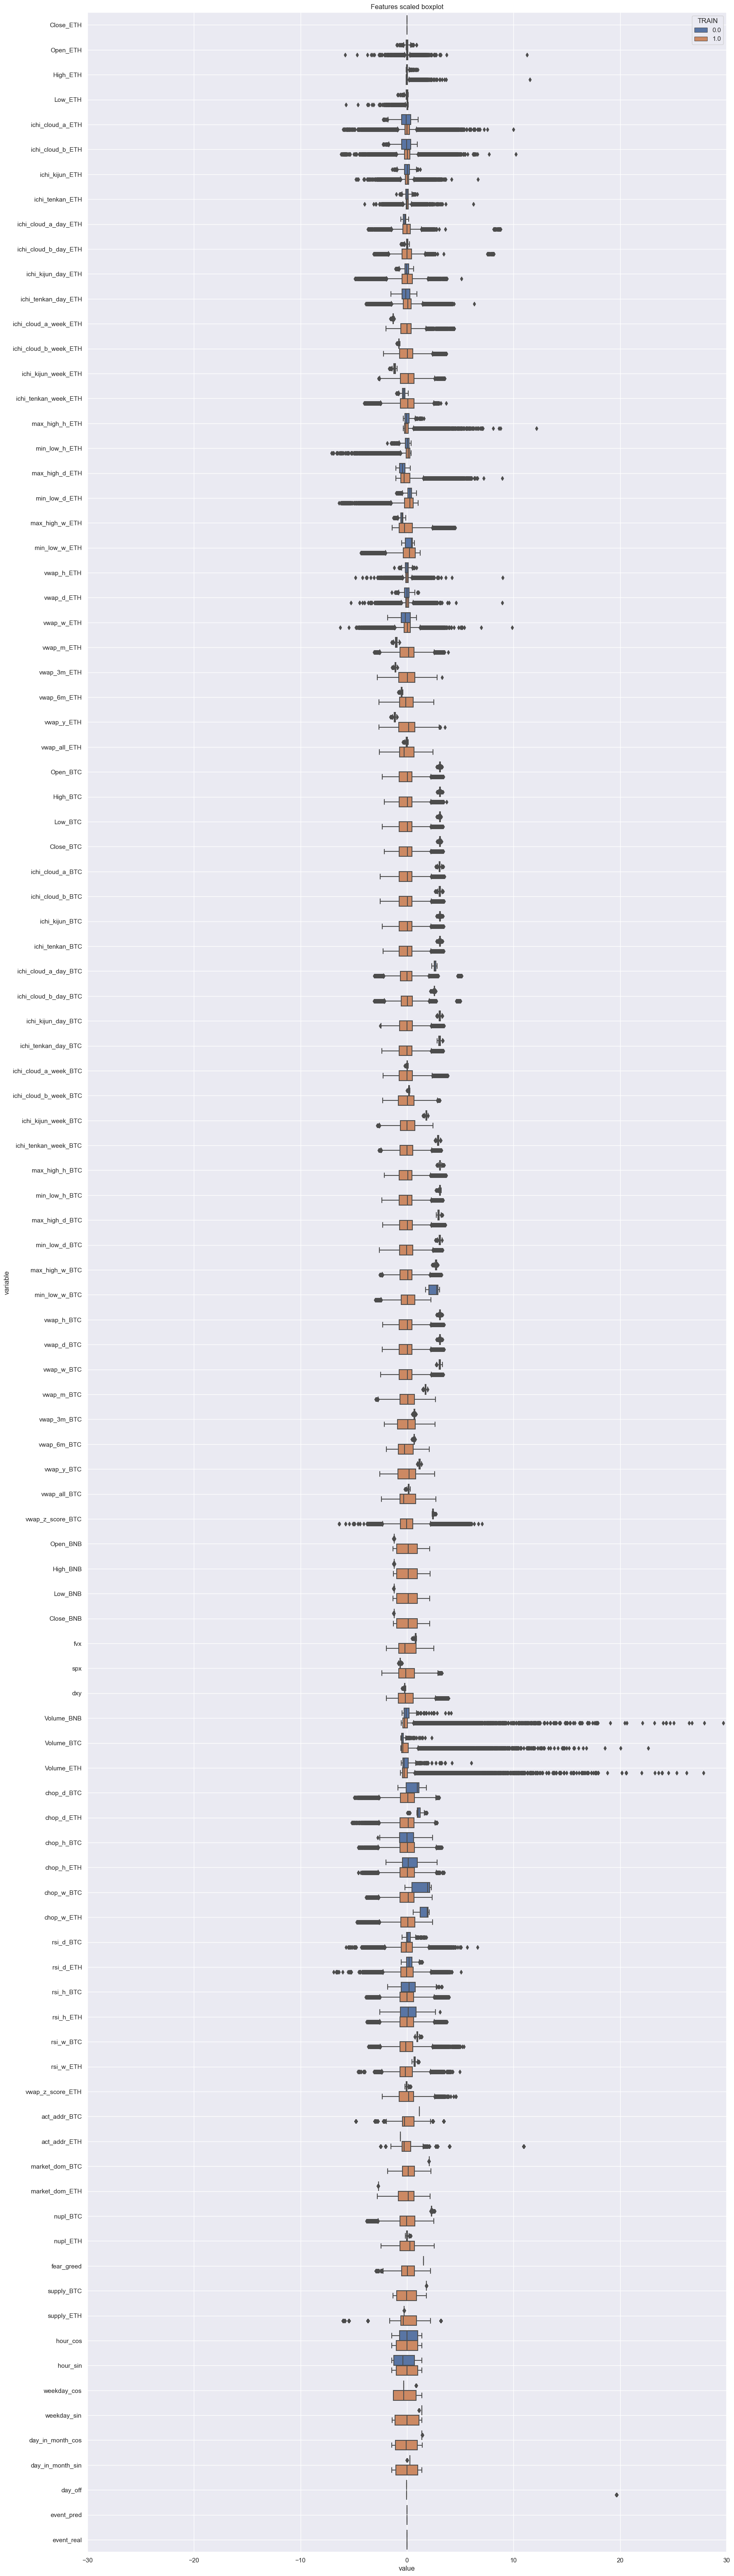

In [62]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<Axes: >

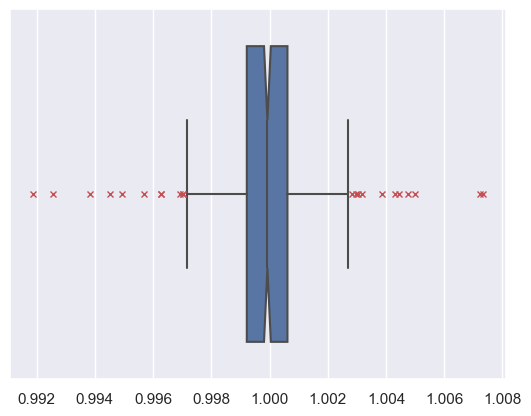

In [63]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


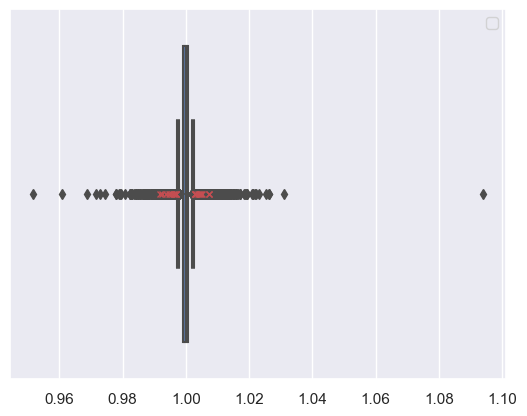

In [64]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

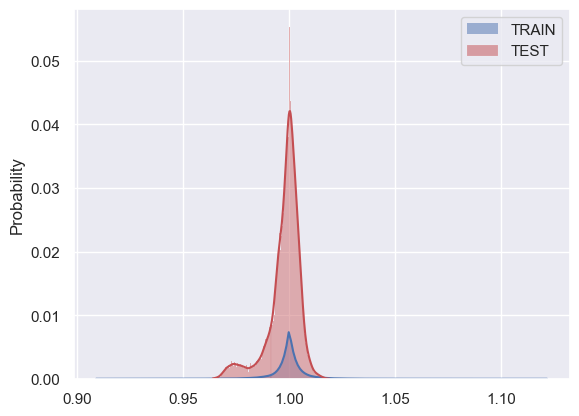

In [65]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [66]:
X_train_sca.shape

(87313, 72, 102)

In [67]:
X_train_sca[:,-1,:].shape

(87313, 102)

In [68]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.10544889],
       [-0.03058061],
       [-0.20481404],
       ...,
       [ 0.26342366],
       [-0.11284442],
       [ 0.13645372]])

In [69]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(87313, 103)

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [72]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

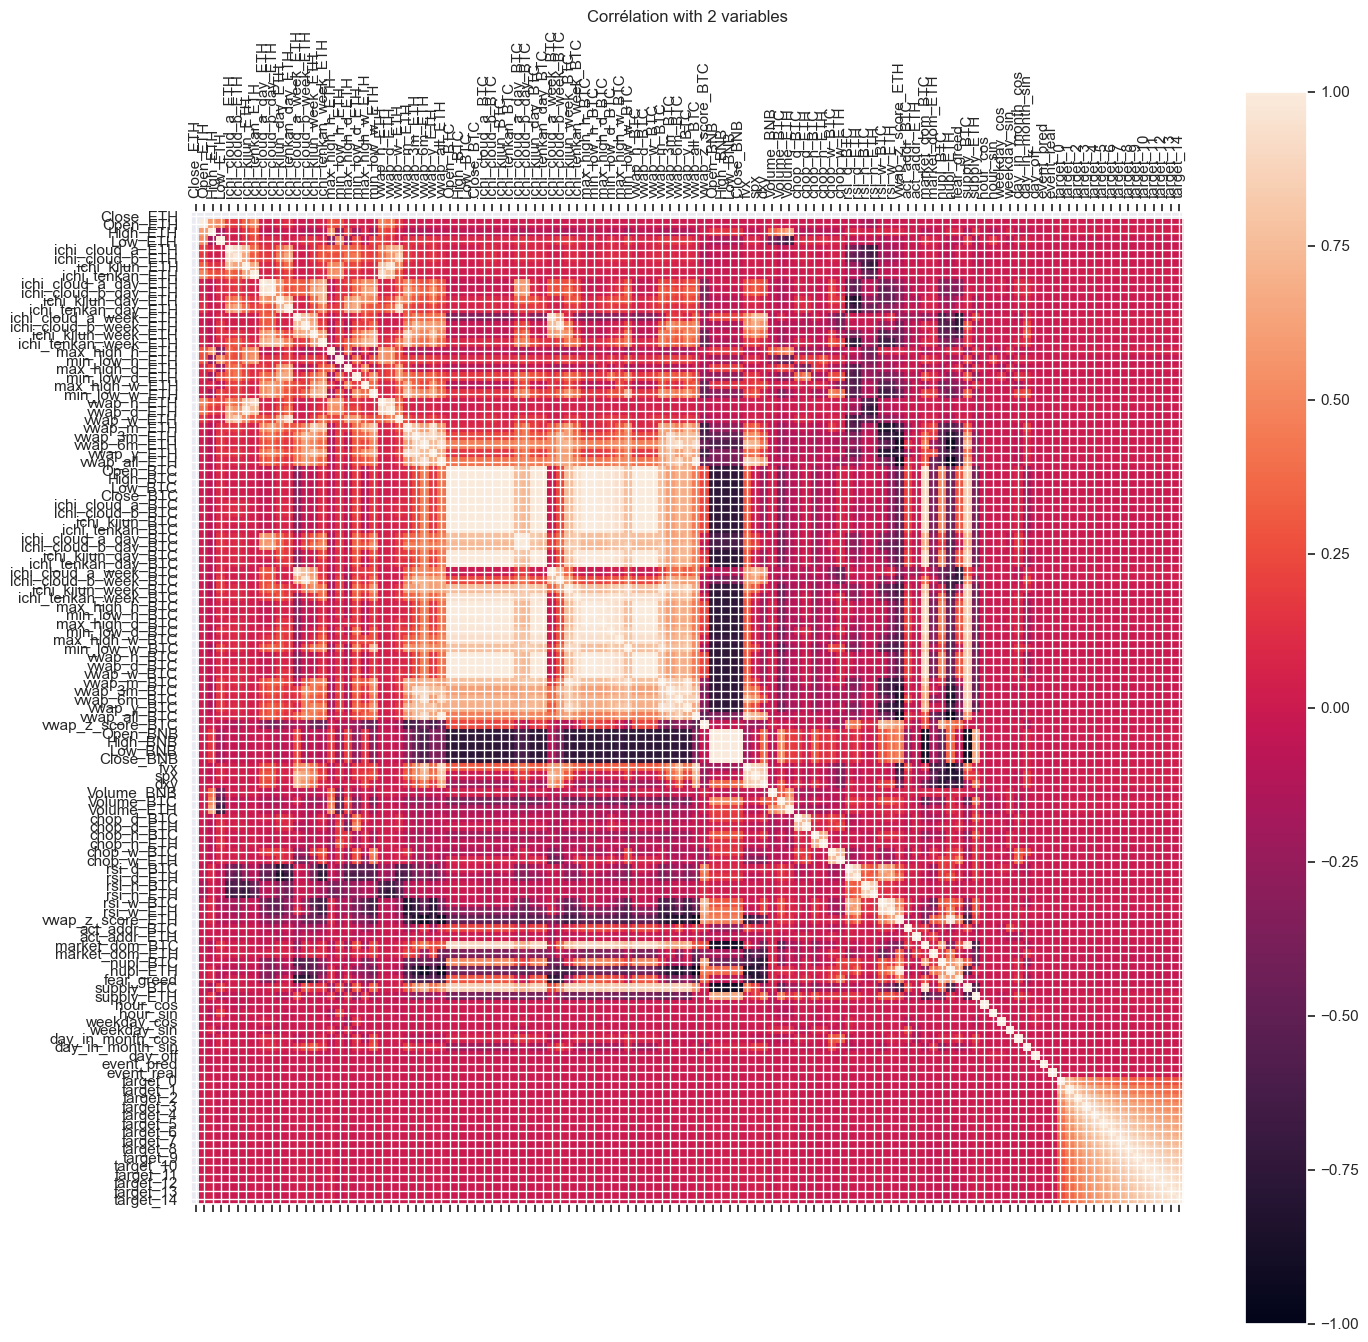

In [73]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


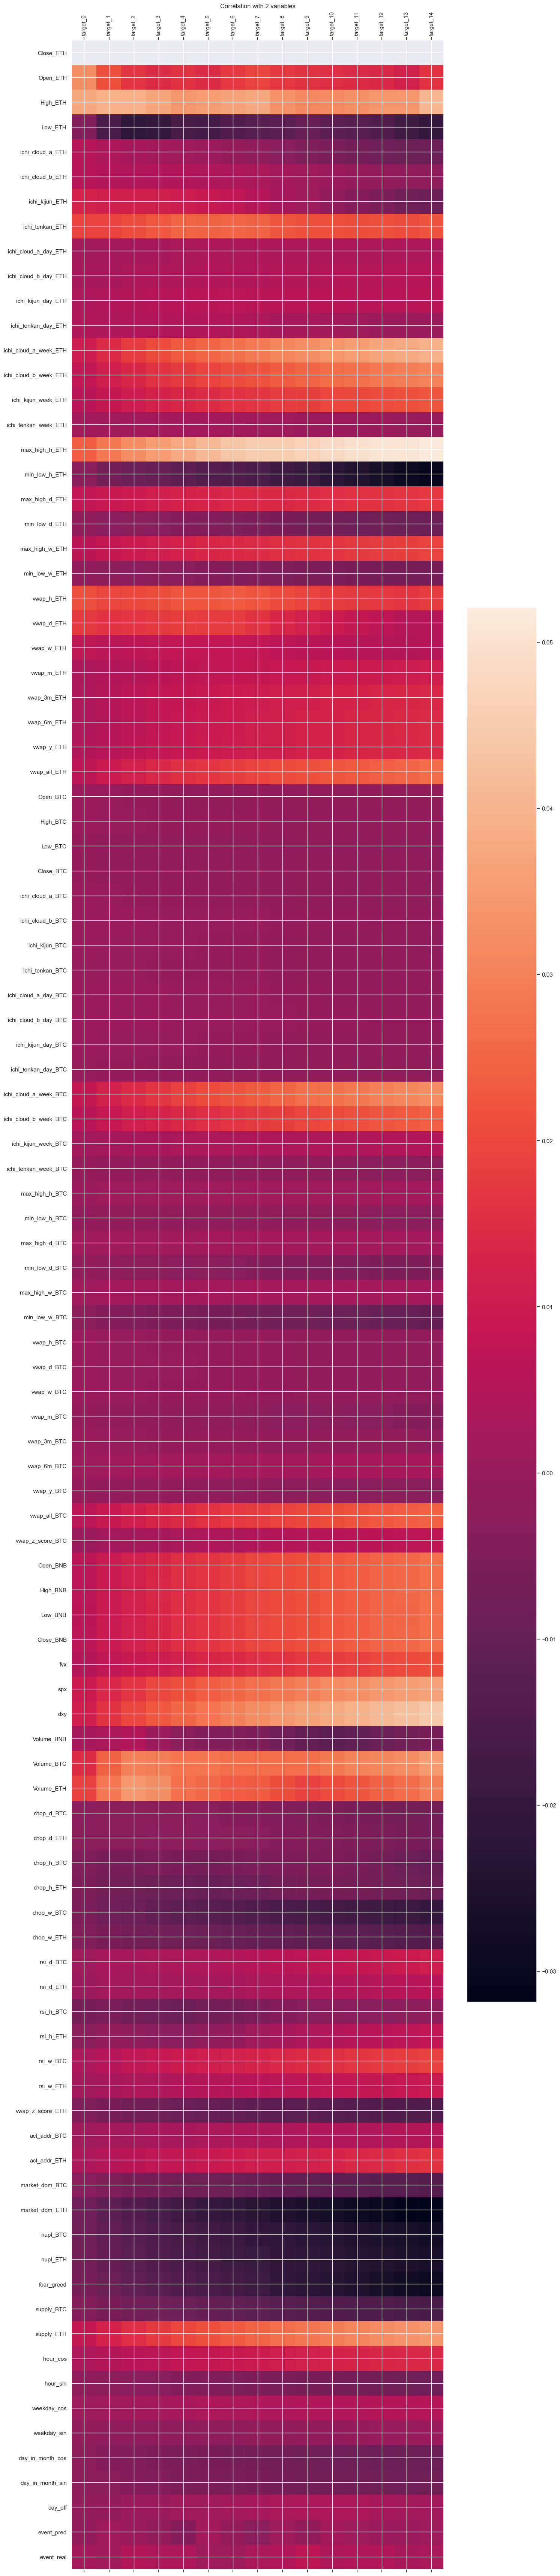

In [74]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


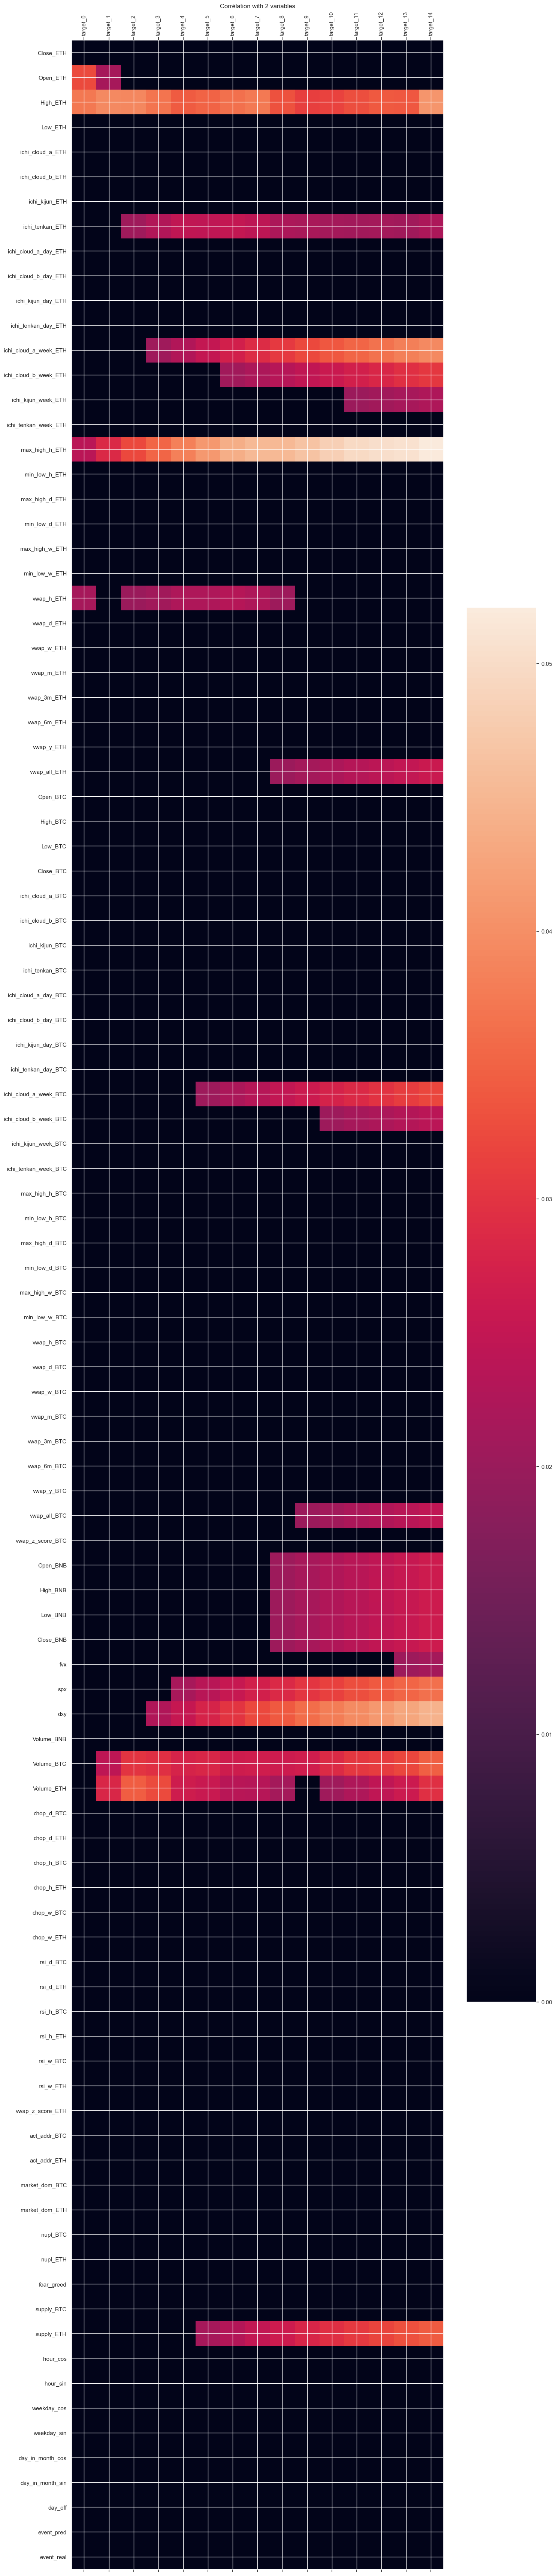

In [75]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [76]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

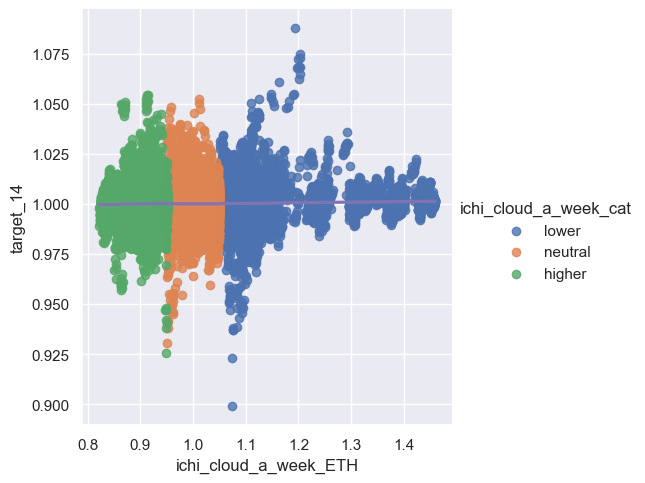

In [77]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

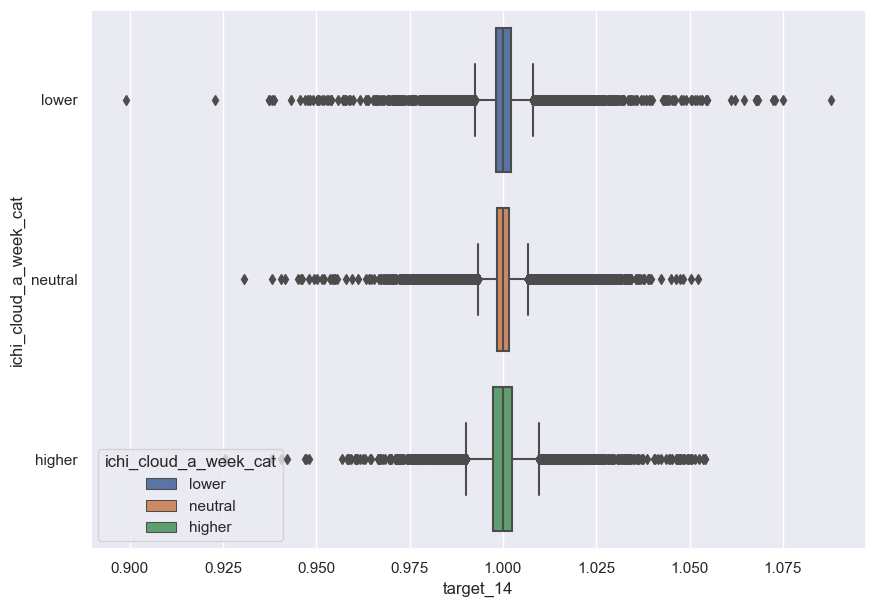

In [78]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [79]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


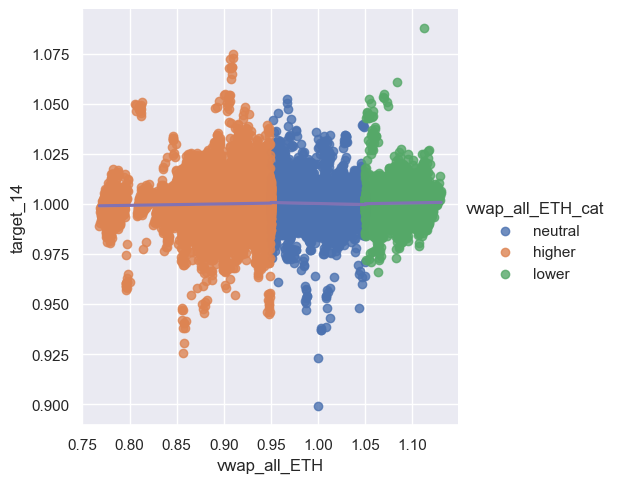

In [80]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<Axes: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

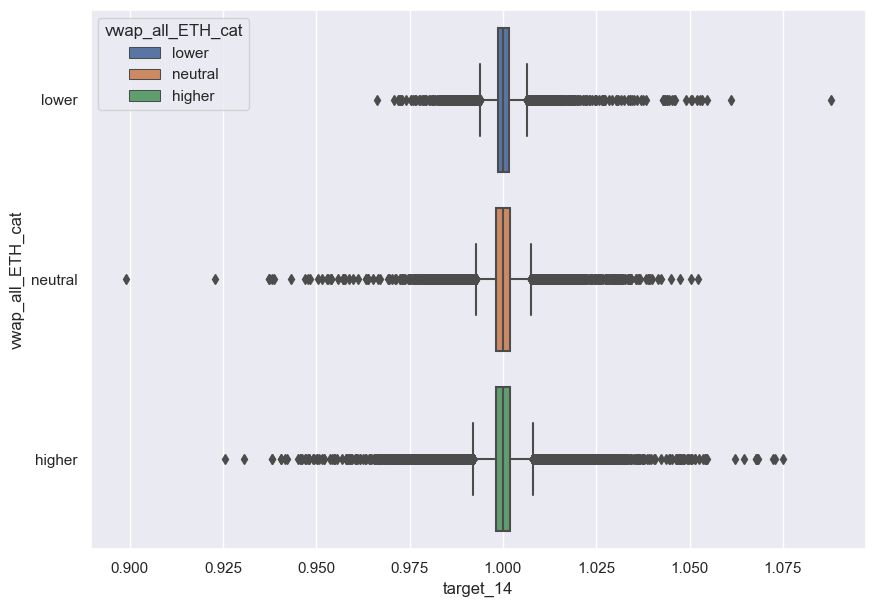

In [81]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

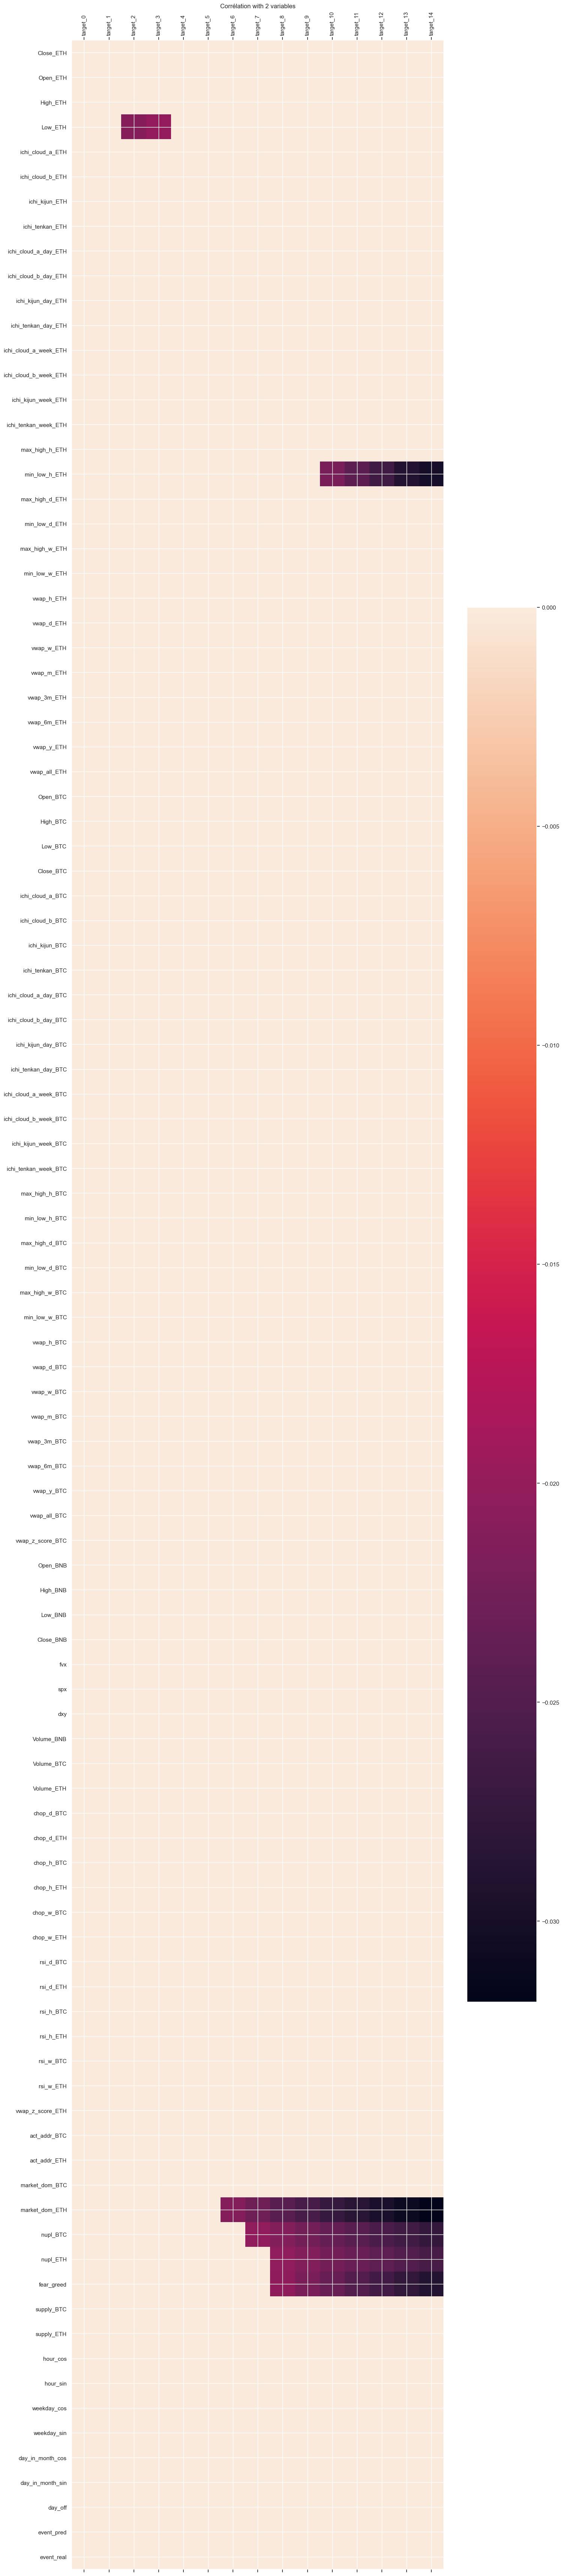

In [82]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

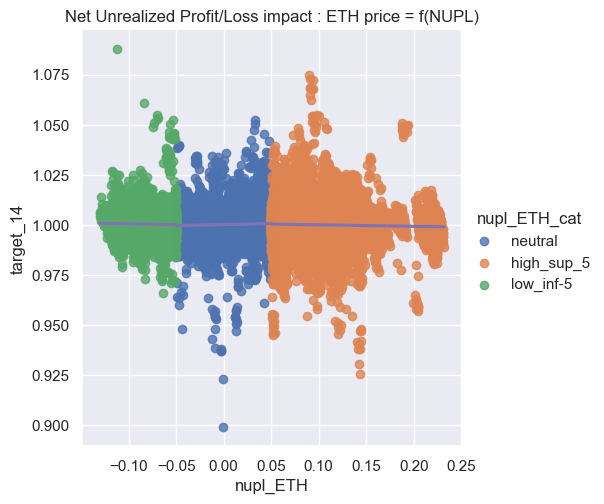

In [83]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

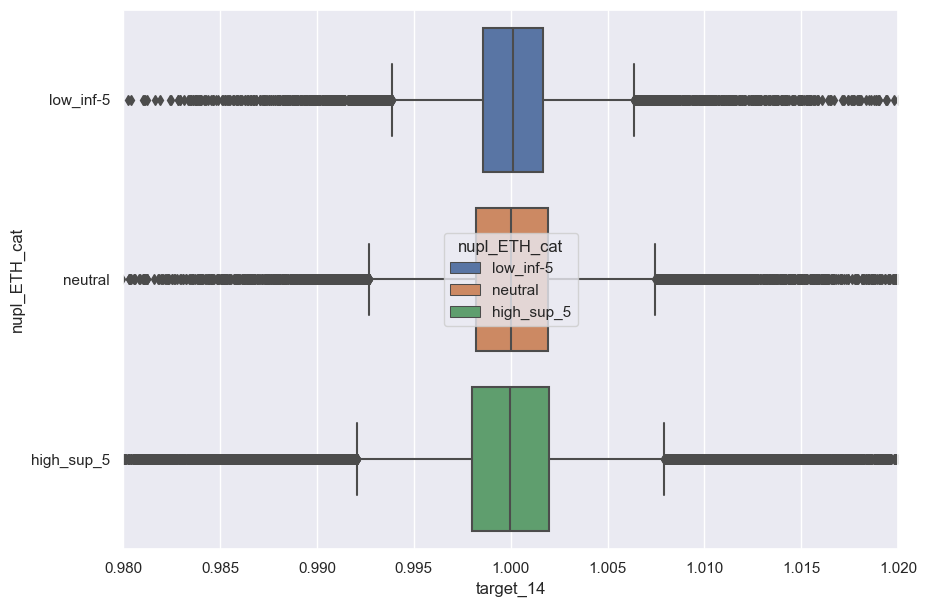

In [84]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [85]:
df["target_14"].describe()

count    87313.000000
mean         1.000085
std          0.005363
min          0.899006
25%          0.998162
50%          1.000018
75%          1.001909
max          1.087790
Name: target_14, dtype: float64

In [86]:
df["target_1"].describe()

count    87313.000000
mean         1.000011
std          0.001998
min          0.907143
25%          0.999286
50%          1.000000
75%          1.000736
max          1.053076
Name: target_1, dtype: float64

<Axes: xlabel='target_14'>

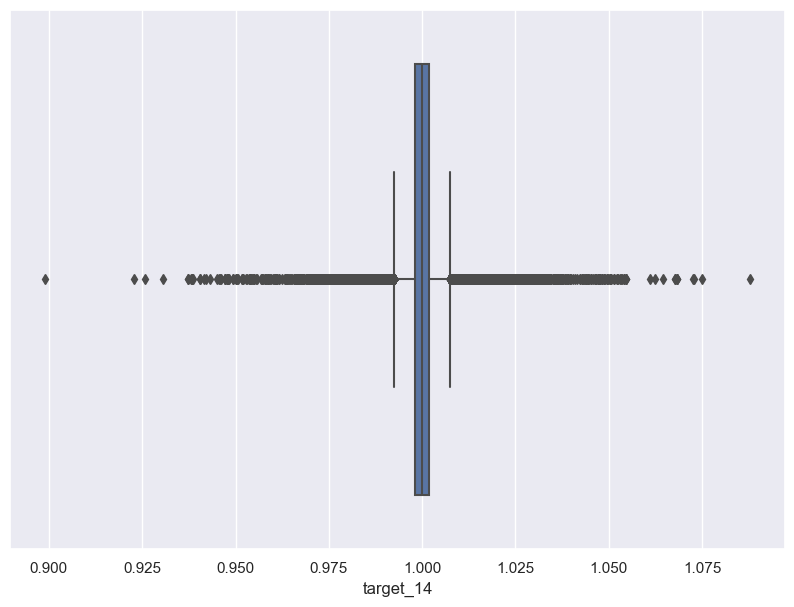

In [87]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [88]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00108259, 1.00068287, 1.0012658 , ..., 1.00087718, 1.00013324,
        1.00105483],
       [0.99960071, 1.00018301, 0.99865238, ..., 0.99905168, 0.99997227,
        0.9990794 ],
       [1.00058254, 0.9990513 , 0.99875171, ..., 1.00037171, 0.99947849,
        0.99946739]])

In [89]:
y_train_sca

array([[ 0.10544889,  0.08631851, -0.10711096, ..., -0.03909181,
         0.02680175, -0.0475942 ],
       [-0.03058061, -0.22392106, -0.05395144, ..., -0.09006998,
        -0.16443169, -0.31527974],
       [-0.20481404, -0.03483161, -0.15594409, ..., -0.14532019,
        -0.29617959, -0.36842213],
       ...,
       [ 0.26342366,  0.16192851,  0.30994226, ...,  0.21126643,
         0.02237269,  0.25637538],
       [-0.11284442,  0.03500927, -0.35363471, ..., -0.25224932,
        -0.01849968, -0.24520867],
       [ 0.13645372, -0.25234551, -0.32841492, ...,  0.08292339,
        -0.14387616, -0.14669354]])

## Autoencoder

### Model creation

### Training

In [90]:
X_train_sca.shape

(87313, 72, 102)

In [91]:
3*3*3*10*35/3600

2.625

In [92]:
#tf.keras.optimizers.AdamW()

In [93]:
#tf.keras.optimizers.legacy.AdamW()

In [94]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
#epochs = 500 #100 #150 #6 #300
#patience = 0 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in LIST_UNITS_AE: #[32, 64, 128]: #[104]: #
        for encoding_dim in LIST_UNITS_ENC_AE:#[16, 20, 32]:
            for dropout_autoenc in LIST_DROPOUT_AE: #[0.05, 0.15, 0.25]: #[0.25]:
                for seed in LIST_SEEDS:
                    # check already done ? 
                    #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                    plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                    path_jpg = os.path.join(path_data,
                        f"output_MSE autoencoder - {plt_name}.jpg")
                    if (MODE_TRAIN_AE == False):
                        print(f"BE CAREFUL ! training inactivated => no training done...")
                        continue
                    print(f"Training: {plt_name} ...")
                    # Init
                    tf.keras.backend.clear_session()
                    np.random.seed(seed)
                    random.seed(seed)
                    tf.random.set_seed(seed)
                    # Input dimension
                    input_dim = X_train.shape[-1]
                    # Reduced encoded input dimension
                    # 64/8/0.5
                    # Définir l'encodeur
                    encoder_inputs = keras.Input(shape=(None, input_dim))
                    encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                    #encoder = layers.LayerNormalization()(encoder)
                    #encoder = layers.Dense(encoding_dim, activation='relu')
                    encoder = layers.Dropout(dropout_autoenc)(encoder)
                    encoder_outputs = layers.Dense(encoding_dim)(encoder)
                    encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                    print(encoder_model.summary())
                    # Définir le décodeur
                    decoder_inputs = keras.Input(shape=(None, encoding_dim))
                    decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                    #decoder = layers.LayerNormalization()(decoder)
                    #decoder = layers.Dense(n_unit_enc, activation='relu')
                    decoder = layers.Dropout(dropout_autoenc)(decoder)
                    decoder_outputs = layers.Dense(input_dim)(decoder)
                    decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                    print(decoder_model.summary())
                    # Define complete autoencoder 
                    autoencoder_inputs = keras.Input(shape=(None, input_dim))
                    encoded = encoder_model(autoencoder_inputs)
                    decoded = decoder_model(encoded)
                    autoencoder = keras.Model(autoencoder_inputs, decoded)
                    # Compile : autoencoder
                    optim = tf.keras.optimizers.legacy.Adam()
                    #optim = tf.keras.optimizers.AdamW()
                    #optim = tf.keras.optimizers.Adam()
                    autoencoder.compile(optimizer=optim, loss="mse")
                    # earlystop 
                    es = EarlyStopping(patience=PATIENCE_AE, verbose=2, min_delta=0.001, 
                                    monitor='val_loss', mode='auto', restore_best_weights=True)
                    # Train
                    if PATIENCE_AE == 0:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1)
                    else:
                        autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                            epochs=EPOCHS_AE, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                            verbose=1, callbacks=[es])

                    plot_train_history(
                        autoenc_step_history,f"MSE autoencoder - {plt_name}",
                        saveFolder=path_data)
                    #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                    #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                                # save the best
                    mse_curr = np.min(autoenc_step_history.history['val_loss'])
                    print("MSE TEST : ", mse_curr)

                    if mse_curr_min == None:
                        seed_min = seed
                        autoenc_step_history_min = autoenc_step_history
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)
                    else:
                        if mse_curr < mse_curr_min:
                            seed_min = seed
                            autoenc_step_history_min = autoenc_step_history
                            mse_curr_min = mse_curr
                            n_unit_enc_min = n_unit_enc
                            encoding_dim_min = encoding_dim
                            dropout_autoenc_min = dropout_autoenc
                            print("Save autoencoder: ", path_mdl_autoencoder)
                            autoencoder.save(path_mdl_autoencoder)
                            print("Save encoder: ", path_mdl_encoder)
                            encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min

print("Load models...")
autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
print(autoencoder.summary())
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print(encoder_model.summary())
n_unit_enc = encoder_model.layers[1].units
dropout_autoenc = encoder_model.layers[2].rate
encoding_dim = encoder_model.layers[3].units
print(f"Model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

if MODE_TRAIN_AE:
    print(f"Best model : seed:{seed} / n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")
    plot_train_history(
        autoenc_step_history_min, 
        f"Best MSE autoencoder - {plt_name}",
        saveFolder=path_data,
    )

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 64)          8704      
                                                                 
 model_1 (Functional)        (None, None, 102)         6918      
                                                                 
Total params: 15622 (61.02 KB)
Trainable params: 15622 (61.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                      

In [95]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [96]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [97]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

2729/2729 [==============================] - 59s 21ms/step


(87313, 72, 102)

### Results

In [98]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

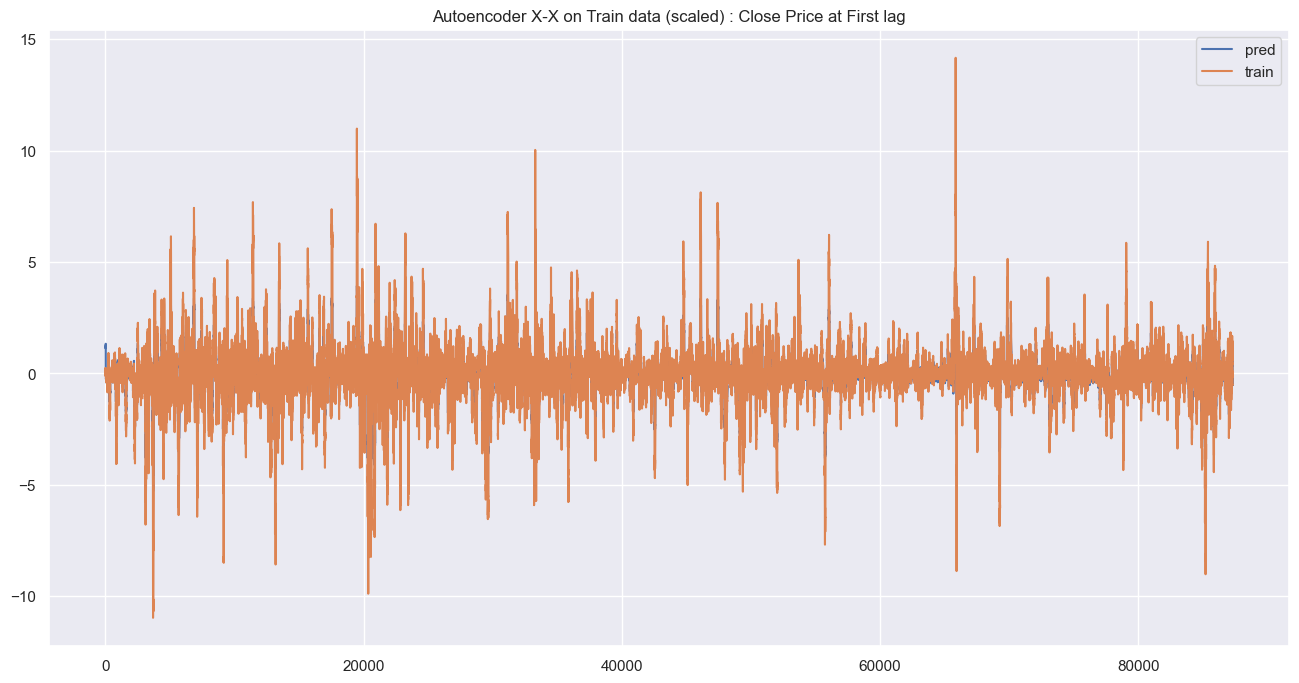

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [100]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(87313, 72, 102)
(87313, 72, 102)
(72, 102)
(1, 102)


In [101]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.355652  0.351465  0.348118  0.353030          0.367552   
lag_1    0.336439  0.332045  0.329586  0.333535          0.350645   
lag_2    0.332789  0.328439  0.325827  0.330193          0.346157   
lag_3    0.329695  0.325451  0.322905  0.326910          0.344658   
lag_4    0.326678  0.322682  0.320062  0.323952          0.343024   
...           ...       ...       ...       ...               ...   
lag_67   0.101994  0.115426  0.100715  0.107571          0.244065   
lag_68   0.094616  0.109614  0.093756  0.100942          0.242037   
lag_69   0.086414  0.103217  0.086011  0.093769          0.240028   
lag_70   0.077531  0.096237  0.077625  0.085652          0.238014   
lag_71   0.065735  0.089537  0.067278  0.076105          0.235944   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.389631        0.352440         0.353184   
lag_1           0.372805        0.332082         0.332973   
lag_2           0.368174        0.327241         0.328753   
lag_3           0.366925        0.324850         0.326064   
lag_4           0.365497        0.322377         0.323444   
...                  ...             ...              ...   
lag_67          0.283411        0.152968         0.130659   
lag_68          0.281900        0.149088         0.126084   
lag_69          0.280280        0.145094         0.121403   
lag_70          0.278745        0.141021         0.116503   
lag_71          0.277134        0.136670         0.111394   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.361975              0.343006  ...    0.437230  0.847707   
lag_1               0.378307              0.353957  ...    0.369586  0.849040   
lag_2               0.370286              0.350540  ...    0.366631  0.851688   
lag_3               0.374315              0.356918  ...    0.369634  0.851975   
lag_4               0.375596              0.359919  ...    0.368533  0.852047   
...                      ...                   ...  ...         ...       ...   
lag_67              0.374341              0.360727  ...    0.365052  0.851812   
lag_68              0.374204              0.360608  ...    0.365041  0.851815   
lag_69              0.374070              0.360486  ...    0.365035  0.851827   
lag_70              0.373930              0.360361  ...    0.365021  0.851835   
lag_71              0.373800              0.360249  ...    0.365012  0.851845   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.734636     0.740361     0.658429          0.732457   
lag_1   0.741206     0.753609     0.656738          0.715391   
lag_2   0.742933     0.753719     0.660088          0.709866   
lag_3   0.742503     0.753231     0.659674          0.706670   
lag_4   0.743035     0.753134     0.659926          0.704925   
...          ...          ...          ...               ...   
lag_67  0.743642     0.752838     0.661078          0.703306   
lag_68  0.743632     0.752838     0.661090          0.703312   
lag_69  0.743626     0.752840     0.661098          0.703317   
lag_70  0.743621     0.752845     0.661104          0.703324   
lag_71  0.743611     0.752850     0.661116          0.703323   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.685461  0.194333    0.035525    0.037865  
lag_1           0.691635  0.188826    0.034303    0.036481  
lag_2           0.684115  0.186676    0.034125    0.035881  
lag_3           0.681874  0.186516    0.034088    0.036092  
lag_4           0.680571  0.186180    0.034107    0.036145  
...                  ...       ...         ...         ...  
lag_67          0.677935  0.185656    0.033928    0.035807  
lag_68          0.677943  0.185650    0.033925    0.035803  
lag_69          0.677950  0.185639    0.033921    0.035799  
lag_70          0.677955  0.185630    0.033916    0.035793  
lag_71          0.677964  0.18561

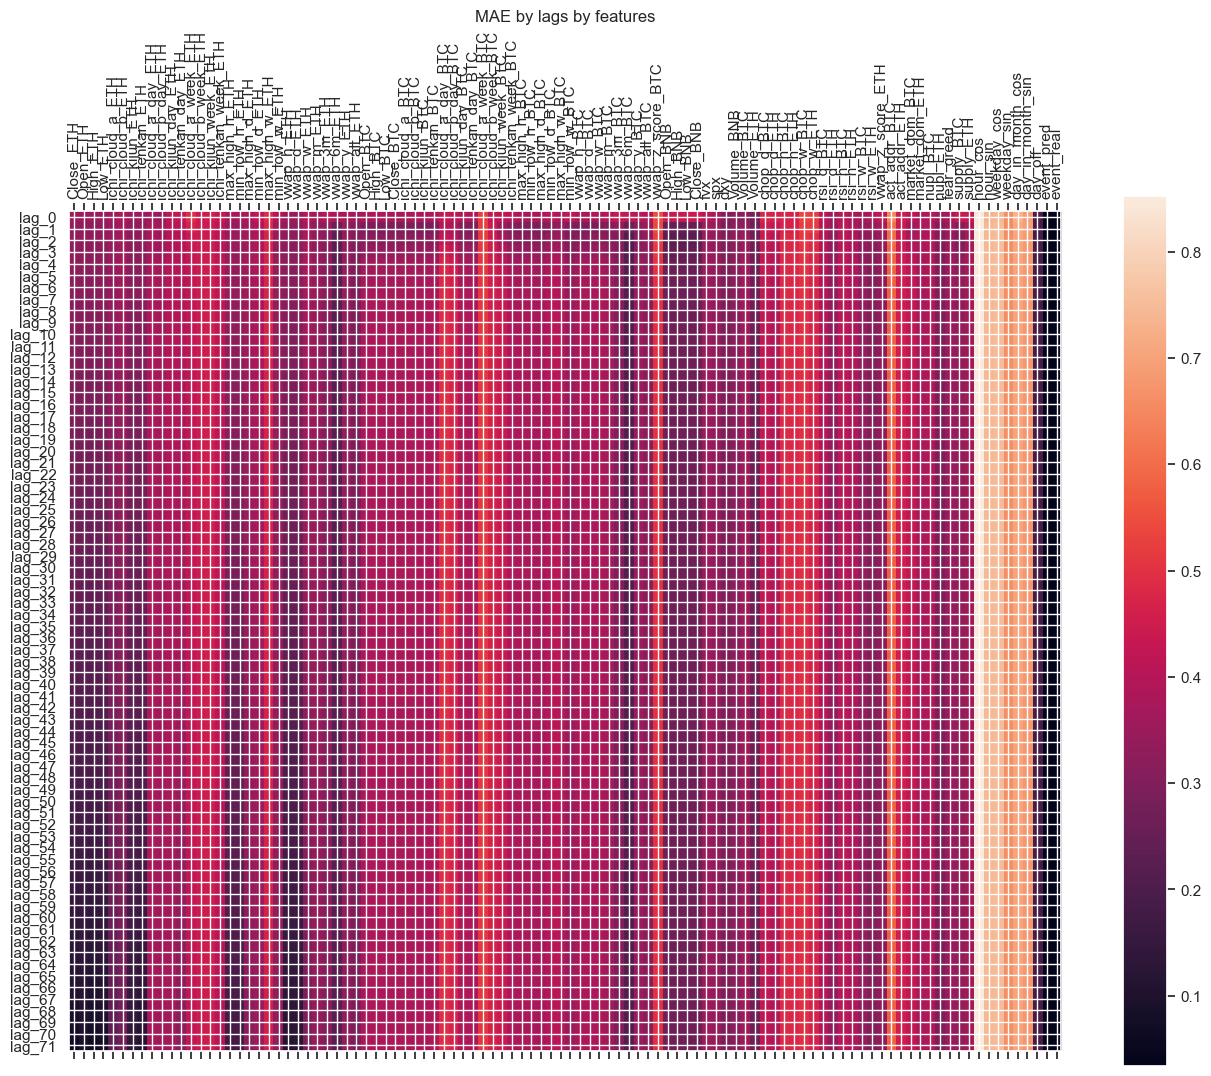

In [102]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_2/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<Axes: >

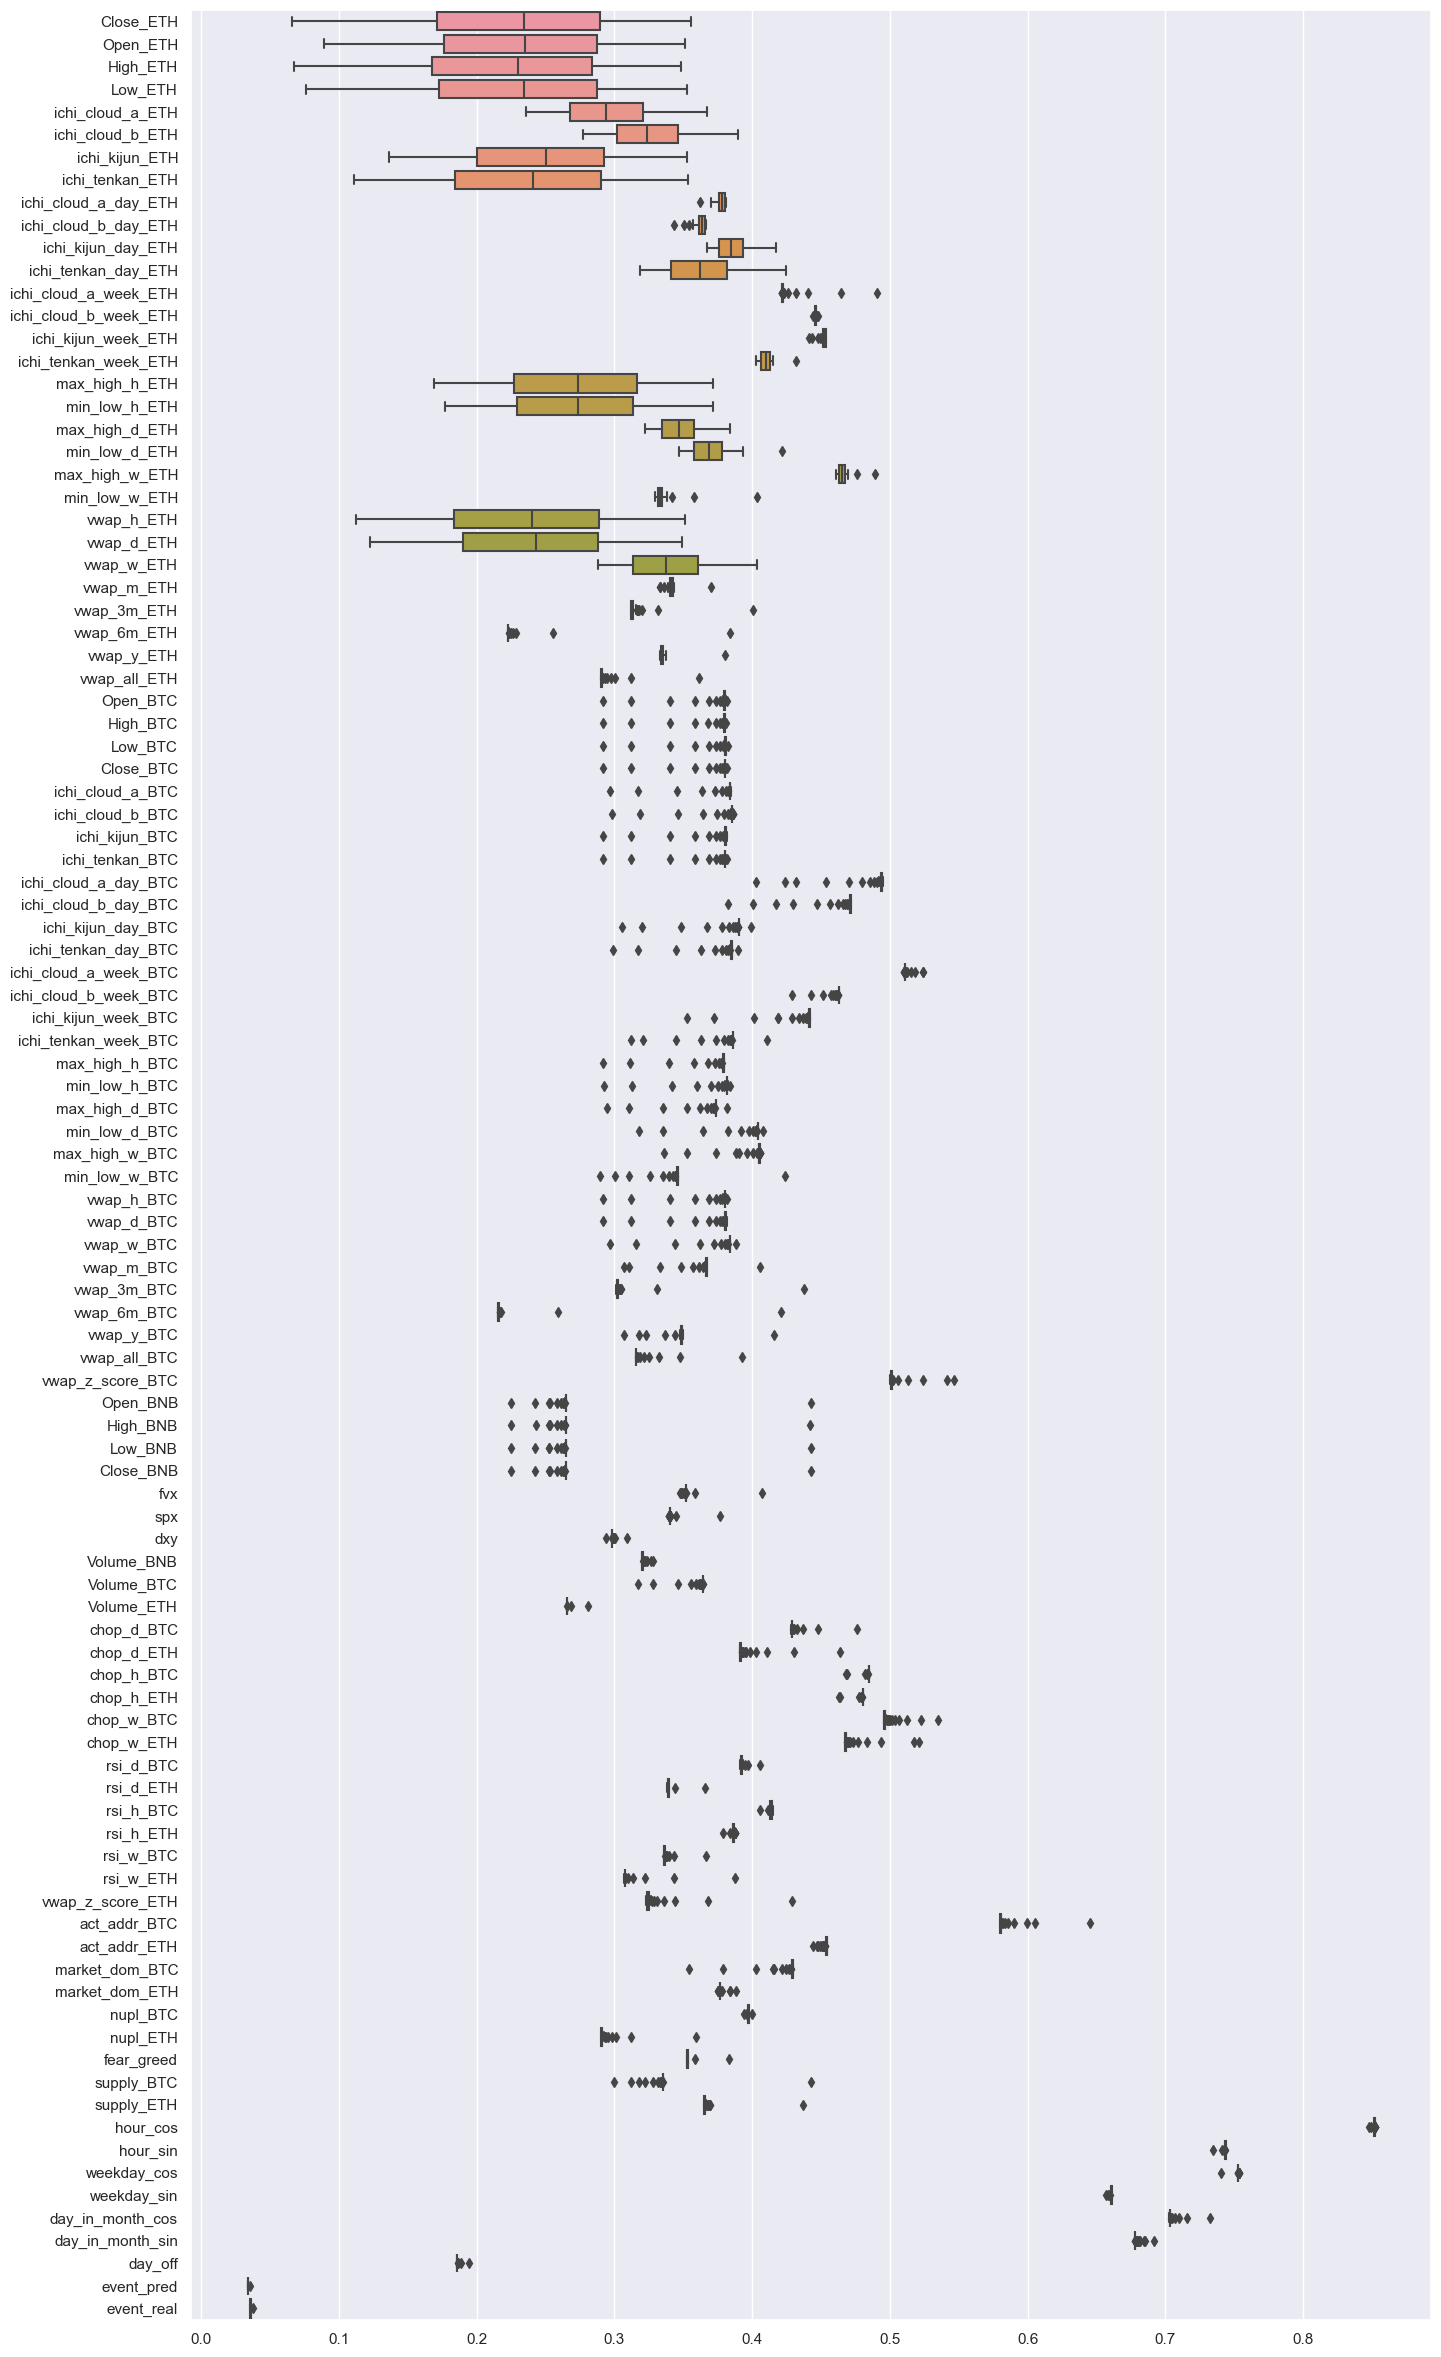

In [103]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [104]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.226675  0.229078   0.22236  0.227017          0.294467   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.324259        0.245355         0.235537              0.377673   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.363189  ...    0.366719  0.851731  0.743345     0.752703   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.660619          0.703847          0.678469  0.186049    0.034067   

   event_real  
0     0.03604  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

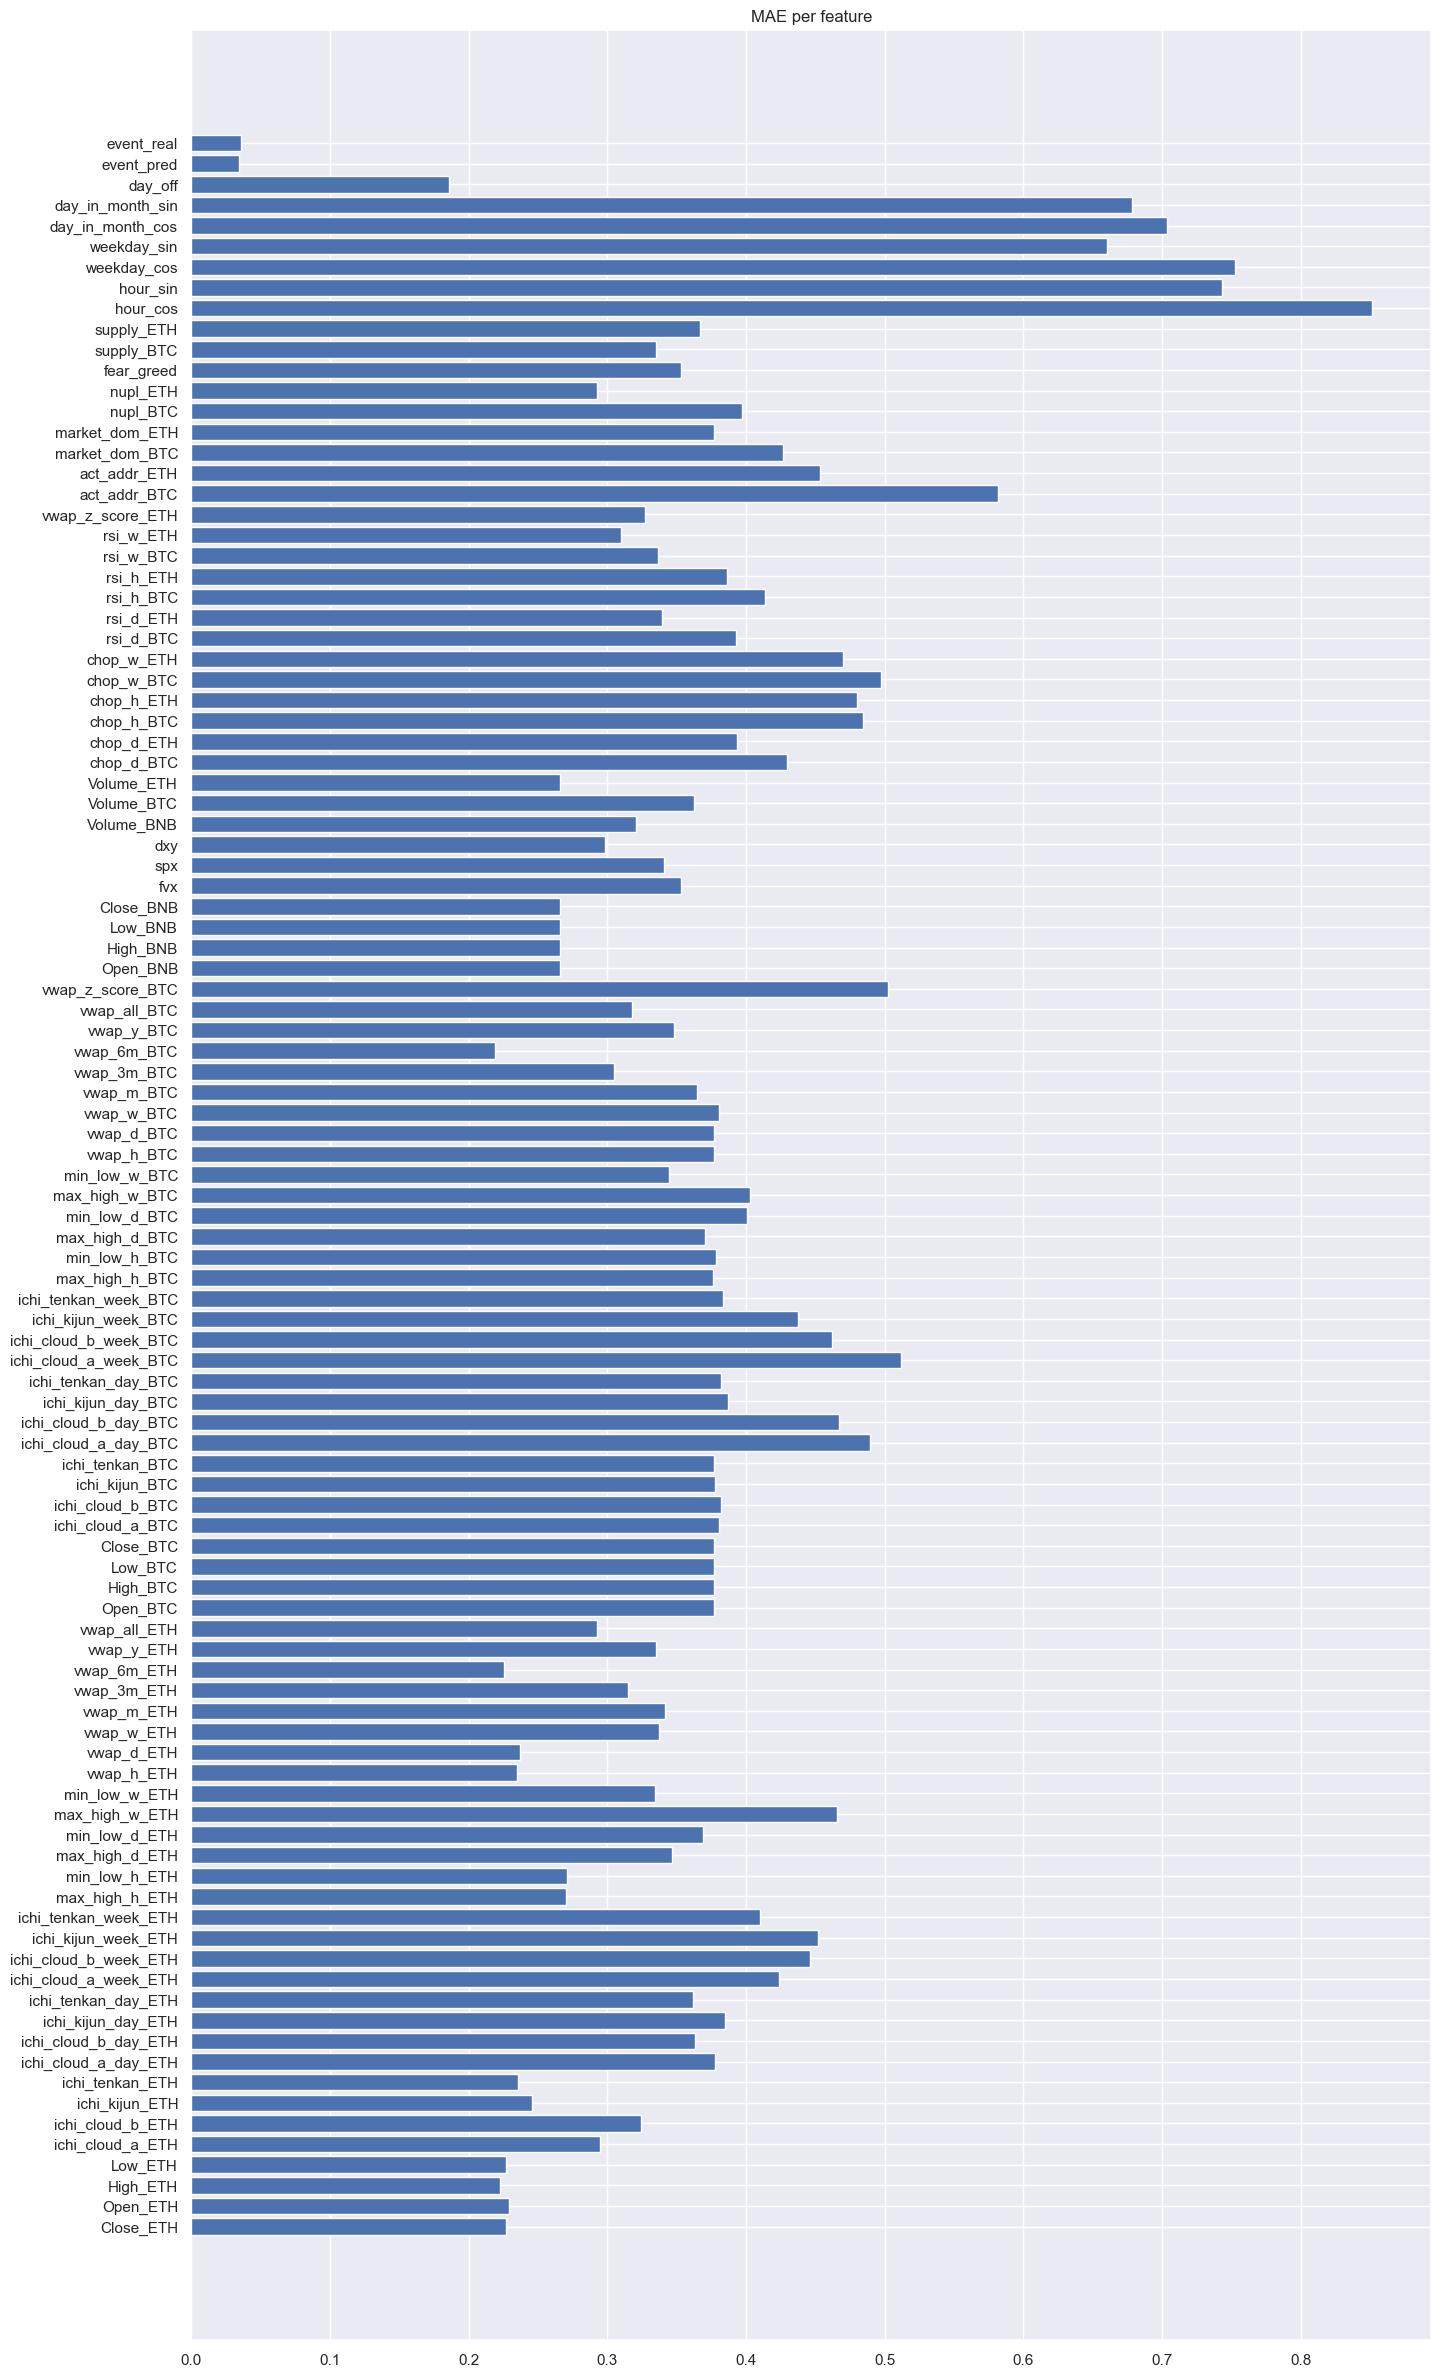

In [105]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [106]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(87313,)
(87313,)
[1196.32 1195.38 1194.55 ... 1796.66 1795.15 1794.53]
[1196.32 1195.38 1194.55]


In [107]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.0000187 , 1.000179  , 1.0002651 , ..., 0.99980867, 0.9998472 ,
       1.0002854 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1796.66 1795.15 1794.53]
[1205.92091396 1206.20760596 1205.96106529 ... 1795.21742415 1795.23491095
 1794.45845696]


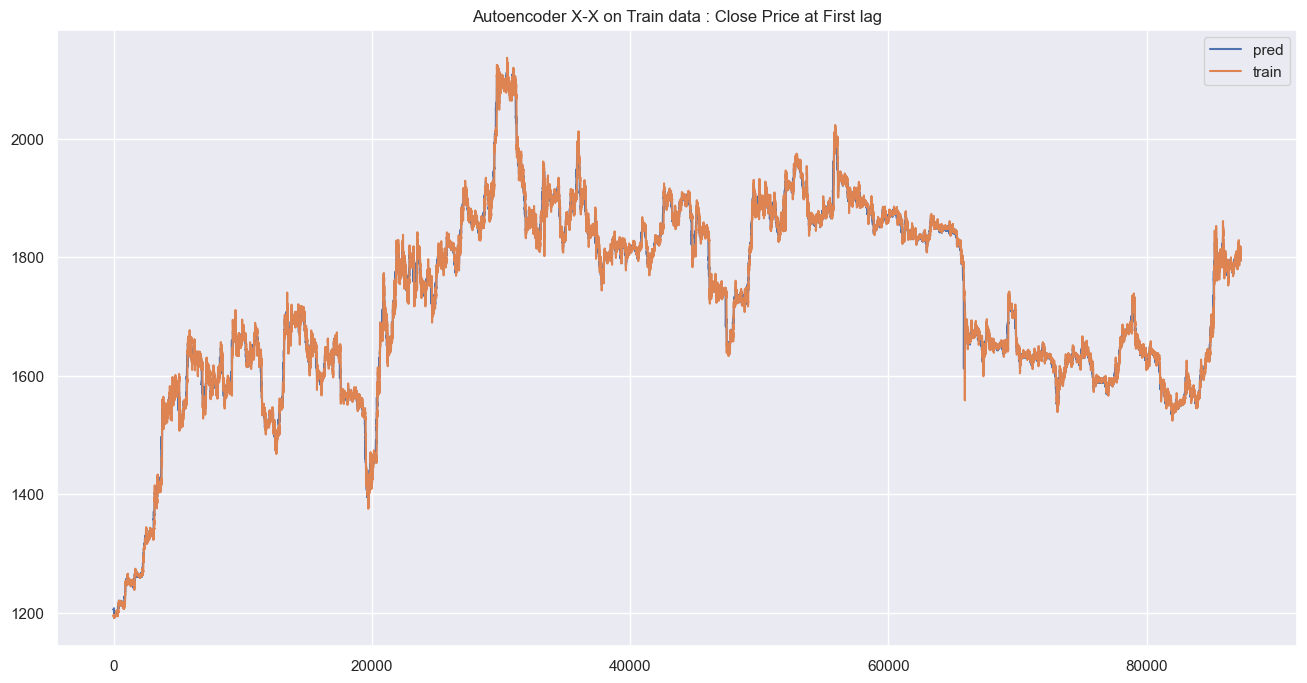

In [108]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [109]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

11/11 [==============================] - 0s 35ms/step


(351, 72, 102)

In [110]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-10-31 11:15:00'

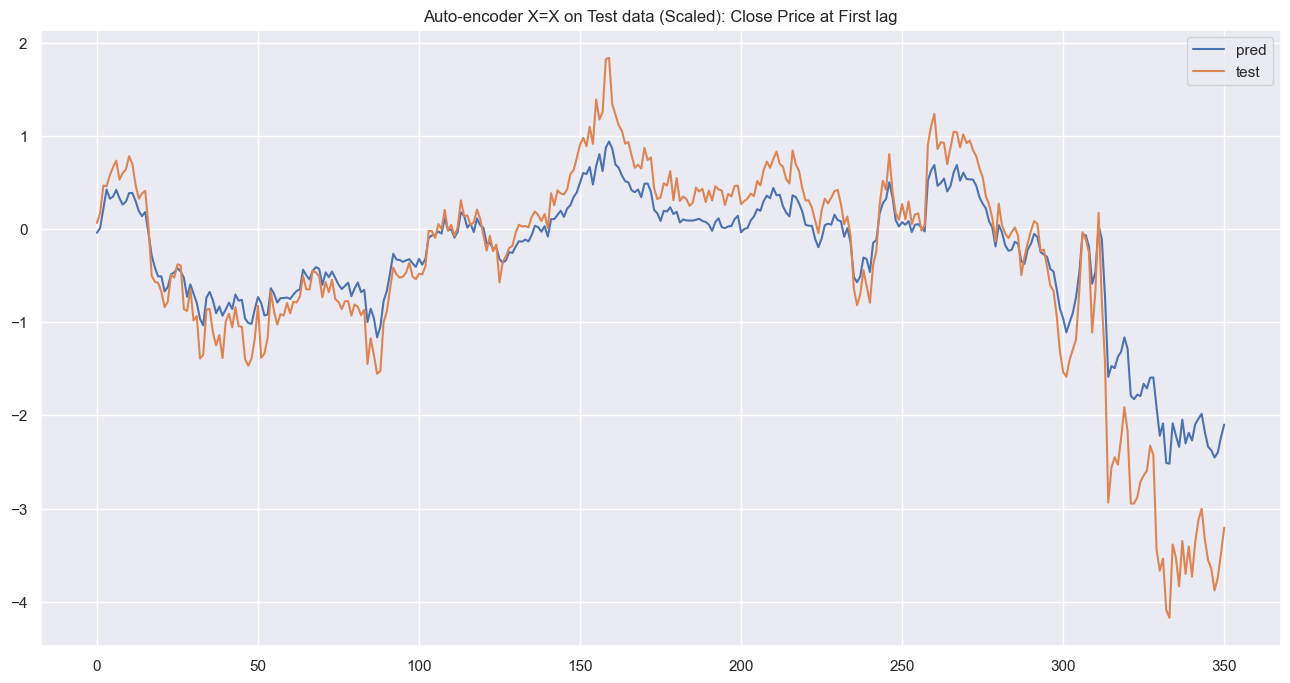

In [111]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [112]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1801.54 1802.75 1807.46 1805.93 1807.69 1809.72 1811.49 1809.41 1810.57]
X test pred :  [1799.96512708 1800.37063584 1803.7976847  1805.4017147  1803.96704018
 1805.07929653 1806.83361964 1806.4318218  1805.56218008]


[1801.54 1802.75 1807.46 1805.93 1807.69 1809.72 1811.49 1809.41 1810.57
 1811.61 1811.68 1811.   1807.9  1804.77 1805.67 1805.05 1803.14 1797.05
 1796.95 1798.76 1798.38 1798.75 1798.09 1801.33 1801.16 1802.17 1804.01
 1796.39 1796.38 1797.86 1792.53 1793.47 1790.51 1791.89 1796.96 1798.45
 1796.11 1794.37 1794.38 1791.   1796.21 1798.45 1799.41 1799.08 1798.
 1795.34 1791.   1788.98 1789.97 1791.35 1795.45 1787.78 1787.36 1789.61
 1792.25 1791.46 1790.85 1792.65 1792.3  1795.92 1795.23 1797.51 1796.97
 1797.69 1802.9  1802.42 1801.81 1803.55 1801.85 1800.5  1800.14 1800.79
 1800.42 1800.77 1799.34 1799.36 1800.14 1800.83 1801.76 1801.9  1802.33
 1800.32 1800.86 1801.11 1800.17 1800.22 1799.2  1802.95 1804.72 1805.61
 1807.58 1808.6  1811.5  1809.95 1808.84 1809.15 1808.04 1810.06 1809.42
 1809.71 1807.69 1807.36 1807.62 1811.47 1812.27 1810.08 1811.47 1812.84
 1813.24 1811.59 1811.9  1811.22 1812.24 1815.42 1811.84 1813.81 1811.22
 1812.06 1811.09 1810.94 1809.14 1807.92 1808.6  1807

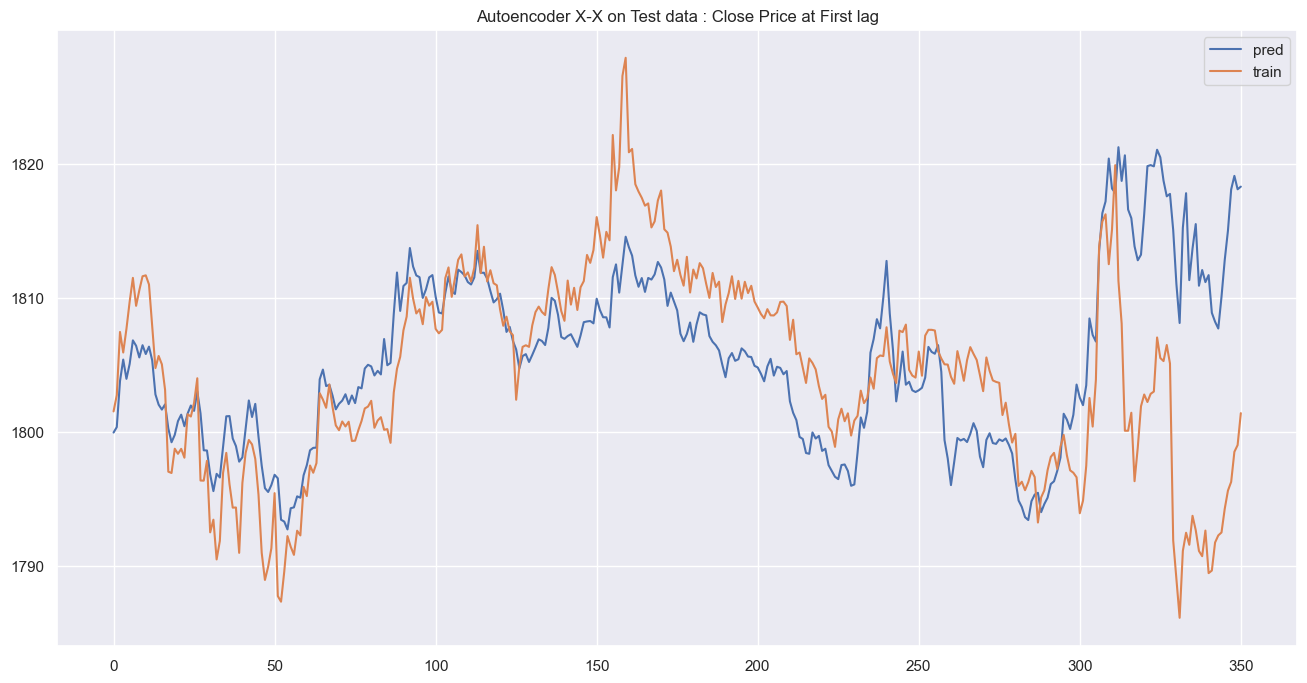

In [113]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [114]:
X_test_sca.shape

(351, 72, 102)

In [115]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.6780793137834839

In [116]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(351, 72, 102)
(351, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.355652  0.351465  0.348118  0.353030          0.367552   
lag_1    0.336439  0.332045  0.329586  0.333535          0.350645   
lag_2    0.332789  0.328439  0.325827  0.330193          0.346157   
lag_3    0.329695  0.325451  0.322905  0.326910          0.344658   
lag_4    0.326678  0.322682  0.320062  0.323952          0.343024   
...           ...       ...       ...       ...               ...   
lag_67   0.117361  0.130812  0.114096  0.122735          0.300183   
lag_68   0.107643  0.123634  0.105072  0.115230          0.300369   
lag_69   0.096343  0.115528  0.098553  0.103188          0.300839   
lag_70   0.081592  0.109928  0.084252  0.093489          0.300367   
lag_71   0.063430  0.098091  0.069110  0.074894          0.300402   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.389631        0.352440         0.353184   
lag_1           0.372805        0.332082         0.332973   
lag_2           0.368174        0.327241         0.328753   
lag_3           0.366925        0.324850         0.326064   
lag_4           0.365497        0.322377         0.323444   
...                  ...             ...              ...   
lag_67          0.309558        0.186856         0.133597   
lag_68          0.310711        0.179543         0.131229   
lag_69          0.312149        0.172027         0.129106   
lag_70          0.312847        0.164462         0.127994   
lag_71          0.315073        0.156171         0.125830   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.361975              0.343006  ...  0.847707  0.734636   
lag_1               0.378307              0.353957  ...  0.849040  0.741206   
lag_2               0.370286              0.350540  ...  0.851688  0.742933   
lag_3               0.374315              0.356918  ...  0.851975  0.742503   
lag_4               0.375596              0.359919  ...  0.852047  0.743035   
...                      ...                   ...  ...       ...       ...   
lag_67              0.639369              0.361958  ...  0.841129  0.802022   
lag_68              0.639134              0.362966  ...  0.843684  0.799911   
lag_69              0.638914              0.363983  ...  0.847024  0.797598   
lag_70              0.638733              0.365033  ...  0.850525  0.795252   
lag_71              0.638493              0.366029  ...  0.853978  0.793116   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.740361     0.658429          0.732457          0.685461   
lag_1      0.753609     0.656738          0.715391          0.691635   
lag_2      0.753719     0.660088          0.709866          0.684115   
lag_3      0.753231     0.659674          0.706670          0.681874   
lag_4      0.753134     0.659926          0.704925          0.680571   
...             ...          ...               ...               ...   
lag_67     0.286863     0.737733          0.290690          0.225182   
lag_68     0.284750     0.736422          0.288937          0.224251   
lag_69     0.282783     0.735274          0.287087          0.223262   
lag_70     0.280683     0.734133          0.285403          0.222282   
lag_71     0.278706     0.733170          0.283771          0.221229   

         day_off  event_pred  event_real  dataset  
lag_0   0.194333    0.035525    0.037865    TRAIN  
lag_1   0.188826    0.034303    0.036481    TRAIN  
lag_2   0.186676    0.034125    0.035881    TRAIN  
lag_3   0.186516    0.034088    0.036092    TRAIN  
lag_4   0.186180    0.034107    0.036145    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.109578    0.041351    0.032970     TEST  
lag_68  0.109974    0.041381    0.032959     TEST  
lag_69  0.110306    0.041406    0.033000     TEST  
lag_70  0.110601    0.041431    0.033066     TEST  
lag_71  0.110695    0.041461    0.033176     TEST  

[144 ro

In [117]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.241116  0.243738  0.238041  0.242084          0.278022   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.288363         0.26363         0.250464              0.642478   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0               0.33134  ...    0.105783  0.831283  0.783861     0.356349   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0      0.74768          0.361477          0.265004  0.098469    0.039293   

   event_real  
0    0.032489  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

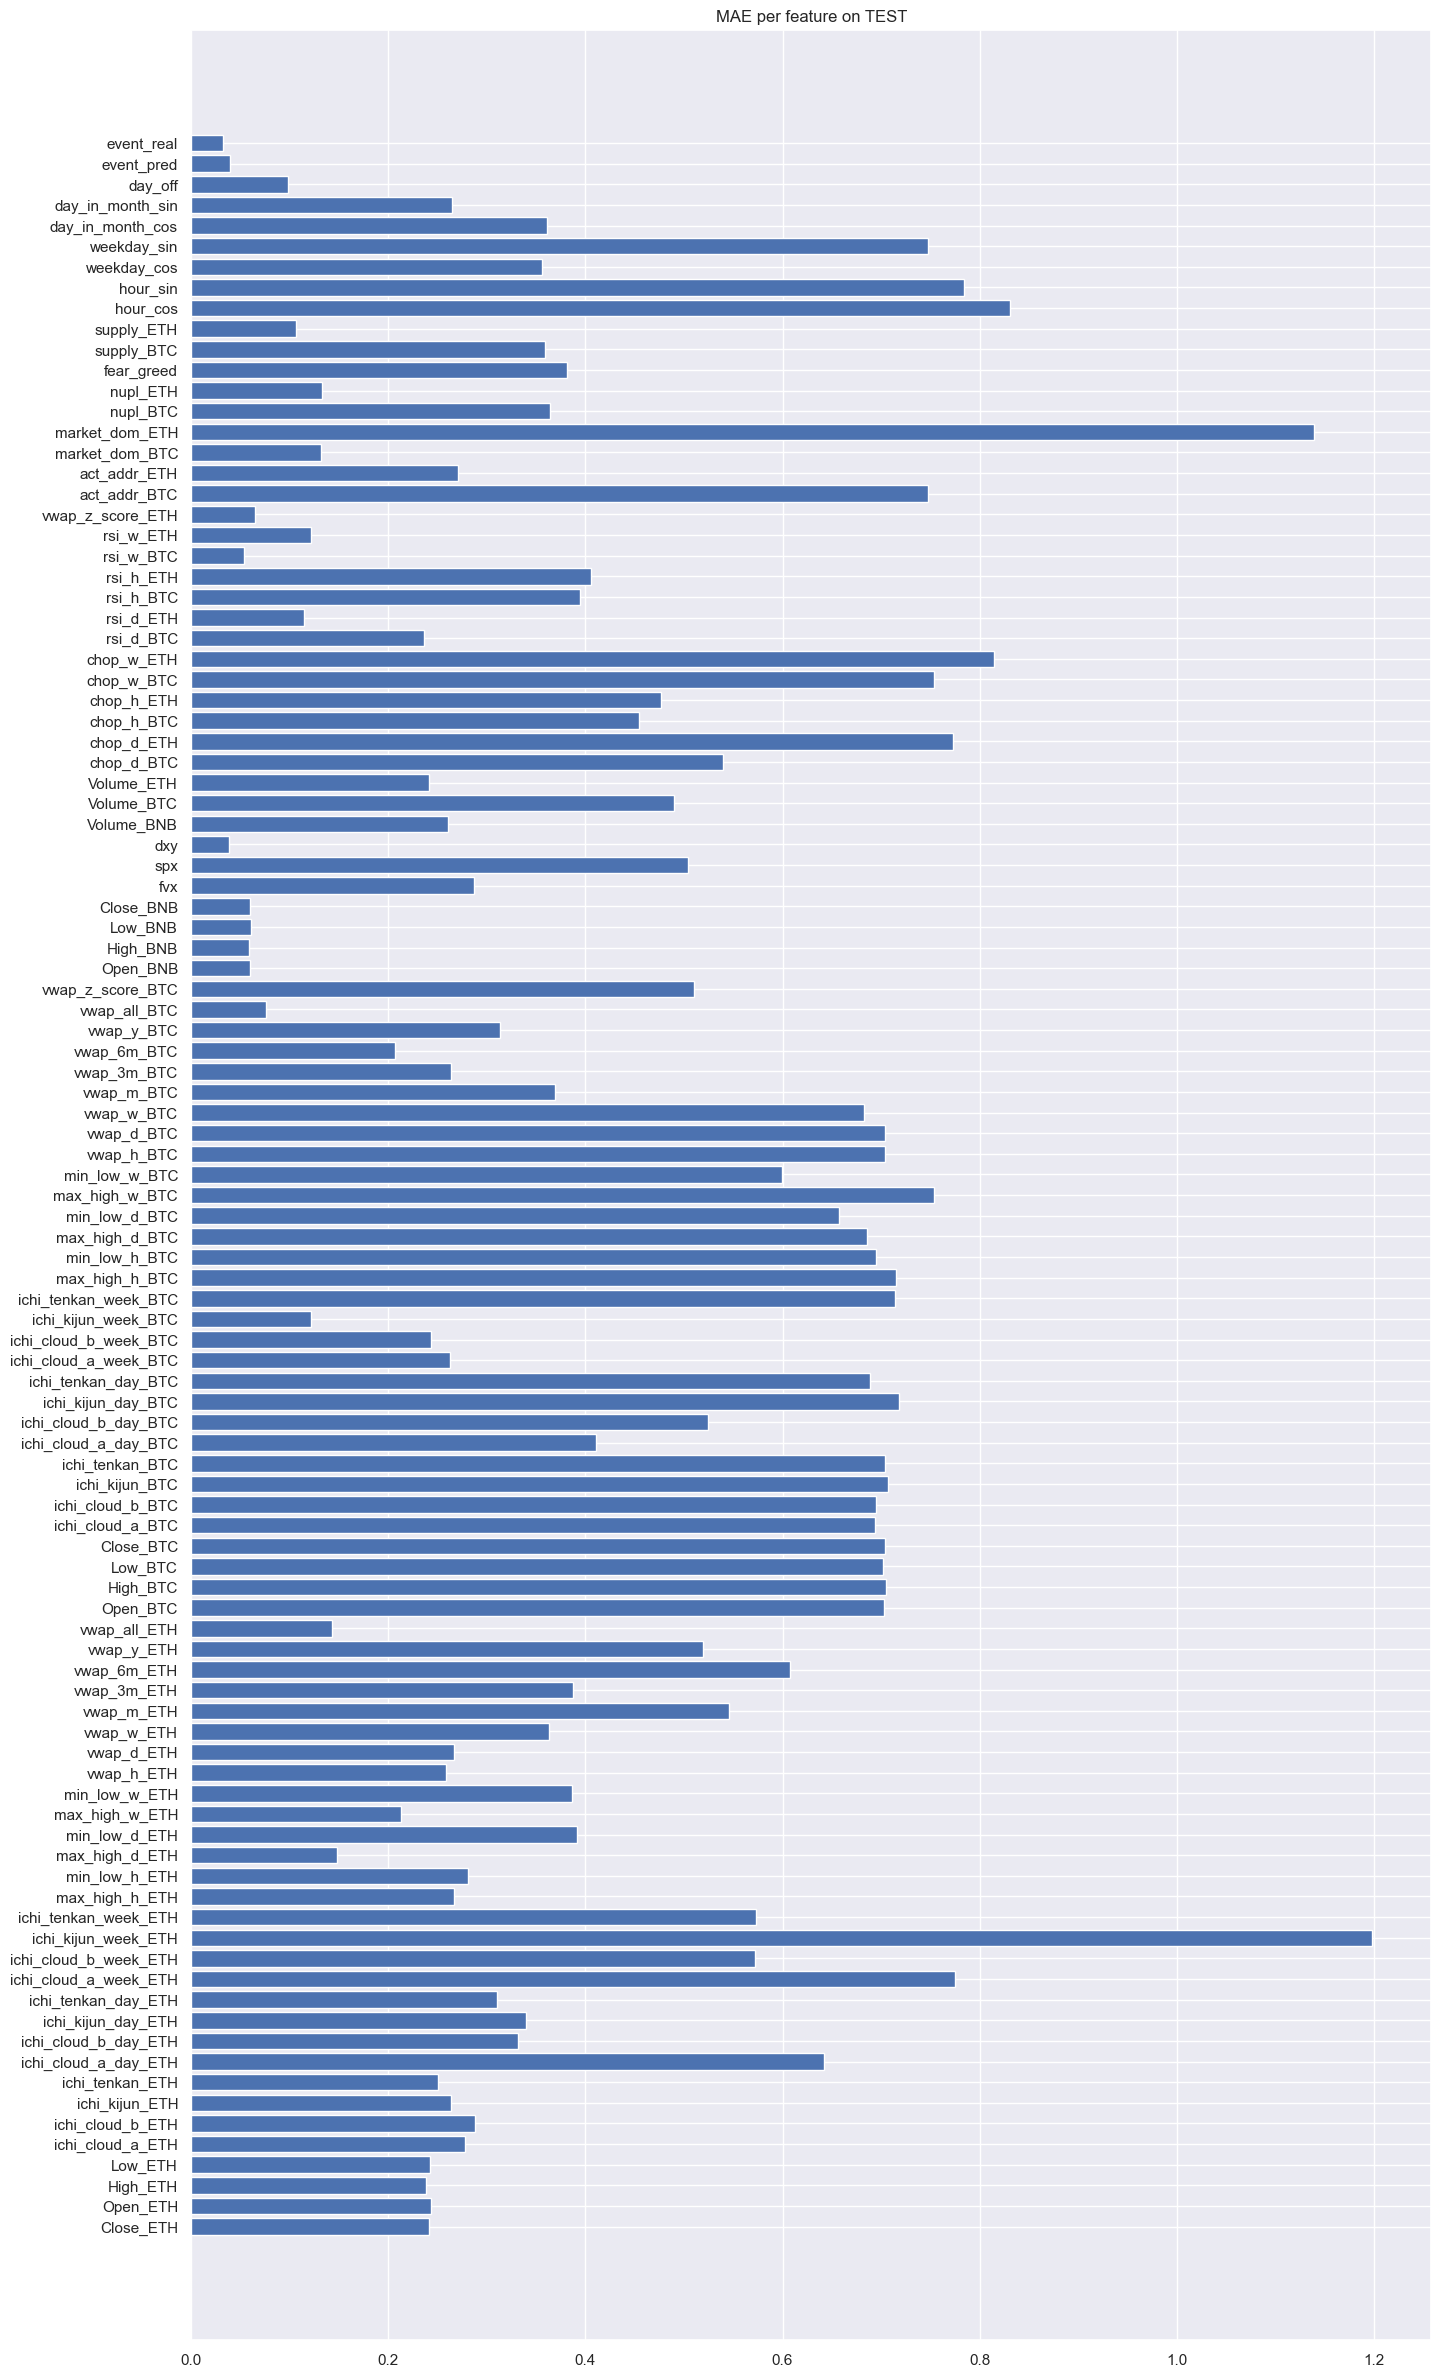

In [118]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [119]:
df_mae_ae_test_feat.values[0]

array([0.24111591, 0.24373844, 0.23804063, 0.24208407, 0.27802159,
       0.28836322, 0.26363035, 0.25046365, 0.64247768, 0.33133995,
       0.33916651, 0.30983563, 0.7750299 , 0.57184101, 1.19853603,
       0.5732146 , 0.26676953, 0.28111017, 0.1475993 , 0.39175682,
       0.21297696, 0.38656814, 0.25805955, 0.26691323, 0.3628901 ,
       0.54601471, 0.38781187, 0.60731524, 0.51976525, 0.14325807,
       0.70342181, 0.705375  , 0.70180233, 0.70375182, 0.69353042,
       0.69444615, 0.70727656, 0.70444002, 0.4108315 , 0.52401808,
       0.71805745, 0.68923983, 0.26248135, 0.24307271, 0.12129265,
       0.71408174, 0.71509675, 0.694394  , 0.68555174, 0.65695767,
       0.75423077, 0.59907286, 0.70415405, 0.70432069, 0.68277029,
       0.36940852, 0.26396833, 0.20713132, 0.3134653 , 0.07627043,
       0.50976786, 0.05953219, 0.05847863, 0.06034716, 0.05940172,
       0.28651792, 0.50451133, 0.03790599, 0.26077598, 0.48959753,
       0.24159687, 0.53951155, 0.77340231, 0.45404909, 0.47681

In [120]:
2/df_mae_ae_test_feat.values[0].sum()

0.04628585375638073

In [121]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.355652
1       TRAIN   Close_ETH  0.336439
2       TRAIN   Close_ETH  0.332789
3       TRAIN   Close_ETH  0.329695
4       TRAIN   Close_ETH  0.326678
...       ...         ...       ...
14683    TEST  event_real  0.032970
14684    TEST  event_real  0.032959
14685    TEST  event_real  0.033000
14686    TEST  event_real  0.033066
14687    TEST  event_real  0.033176

[14688 rows x 3 columns]

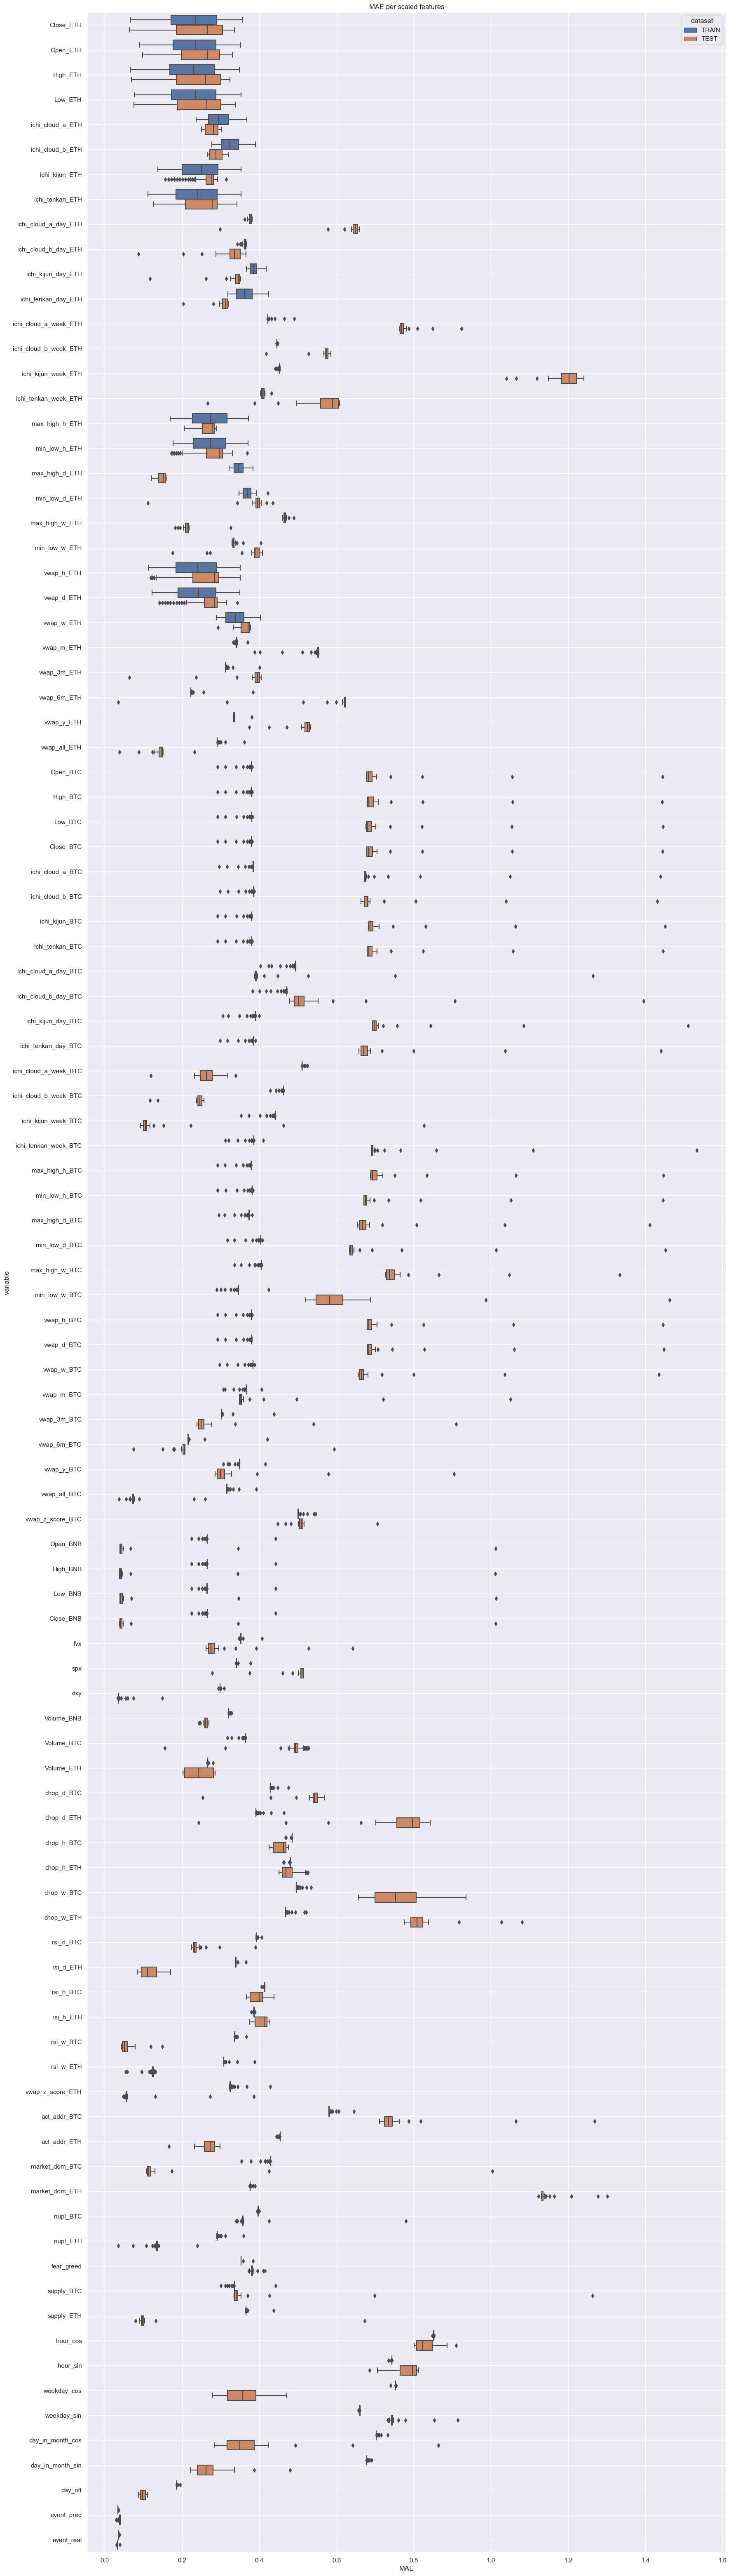

In [122]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [123]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(87313, 72, 102)
(87313, 72, 102)
(72, 102)
(351, 72, 102)
(351, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [124]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.145628  0.145252  0.140877  0.143806          0.276551   
0   0.134088  0.132415  0.126795  0.137420          0.150158   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.294614        0.152970         0.146007              0.266895   
0          0.142864        0.136786         0.137897              0.420105   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.234297  ...  0.910804  0.694887     0.701264     0.576770   
0              0.125733  ...  0.875034  0.755660     0.224461     0.583062   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.647660          0.611505  0.854383    0.997501    0.995755   
0          0.254165          0.098427  0.013628    0.001909    0.001483   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

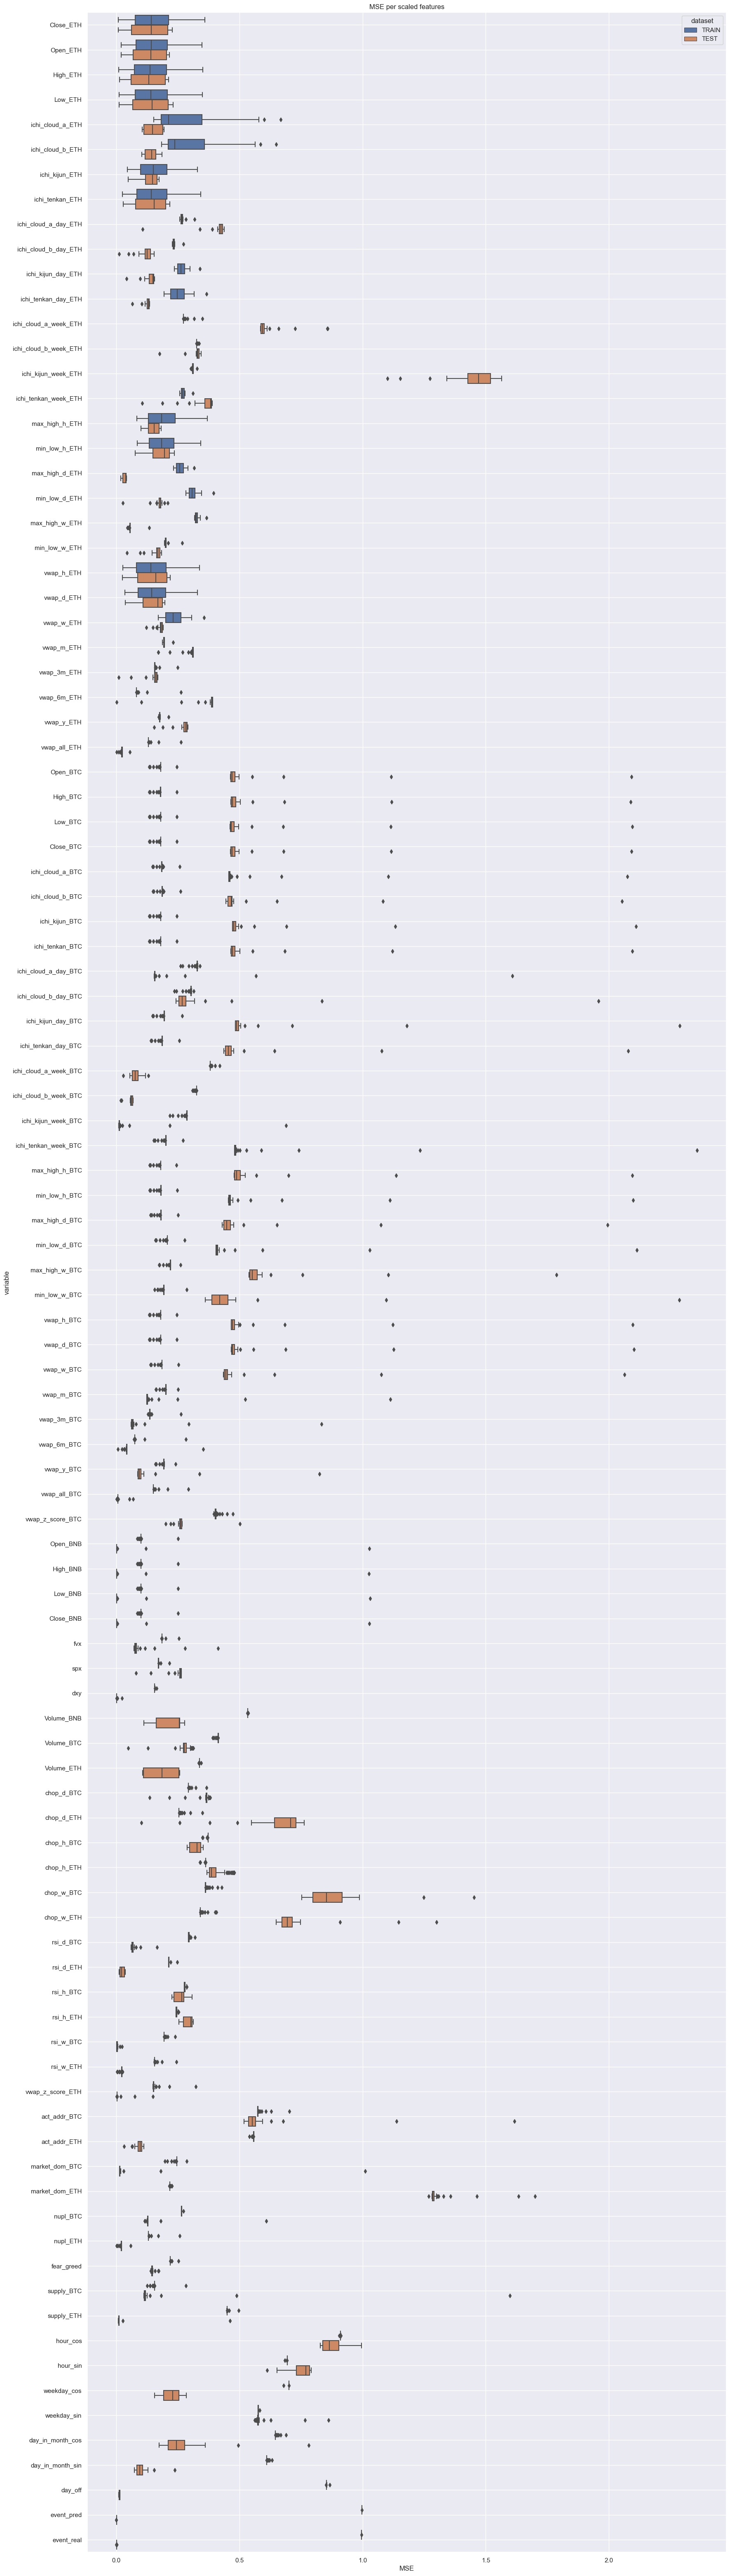

In [125]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

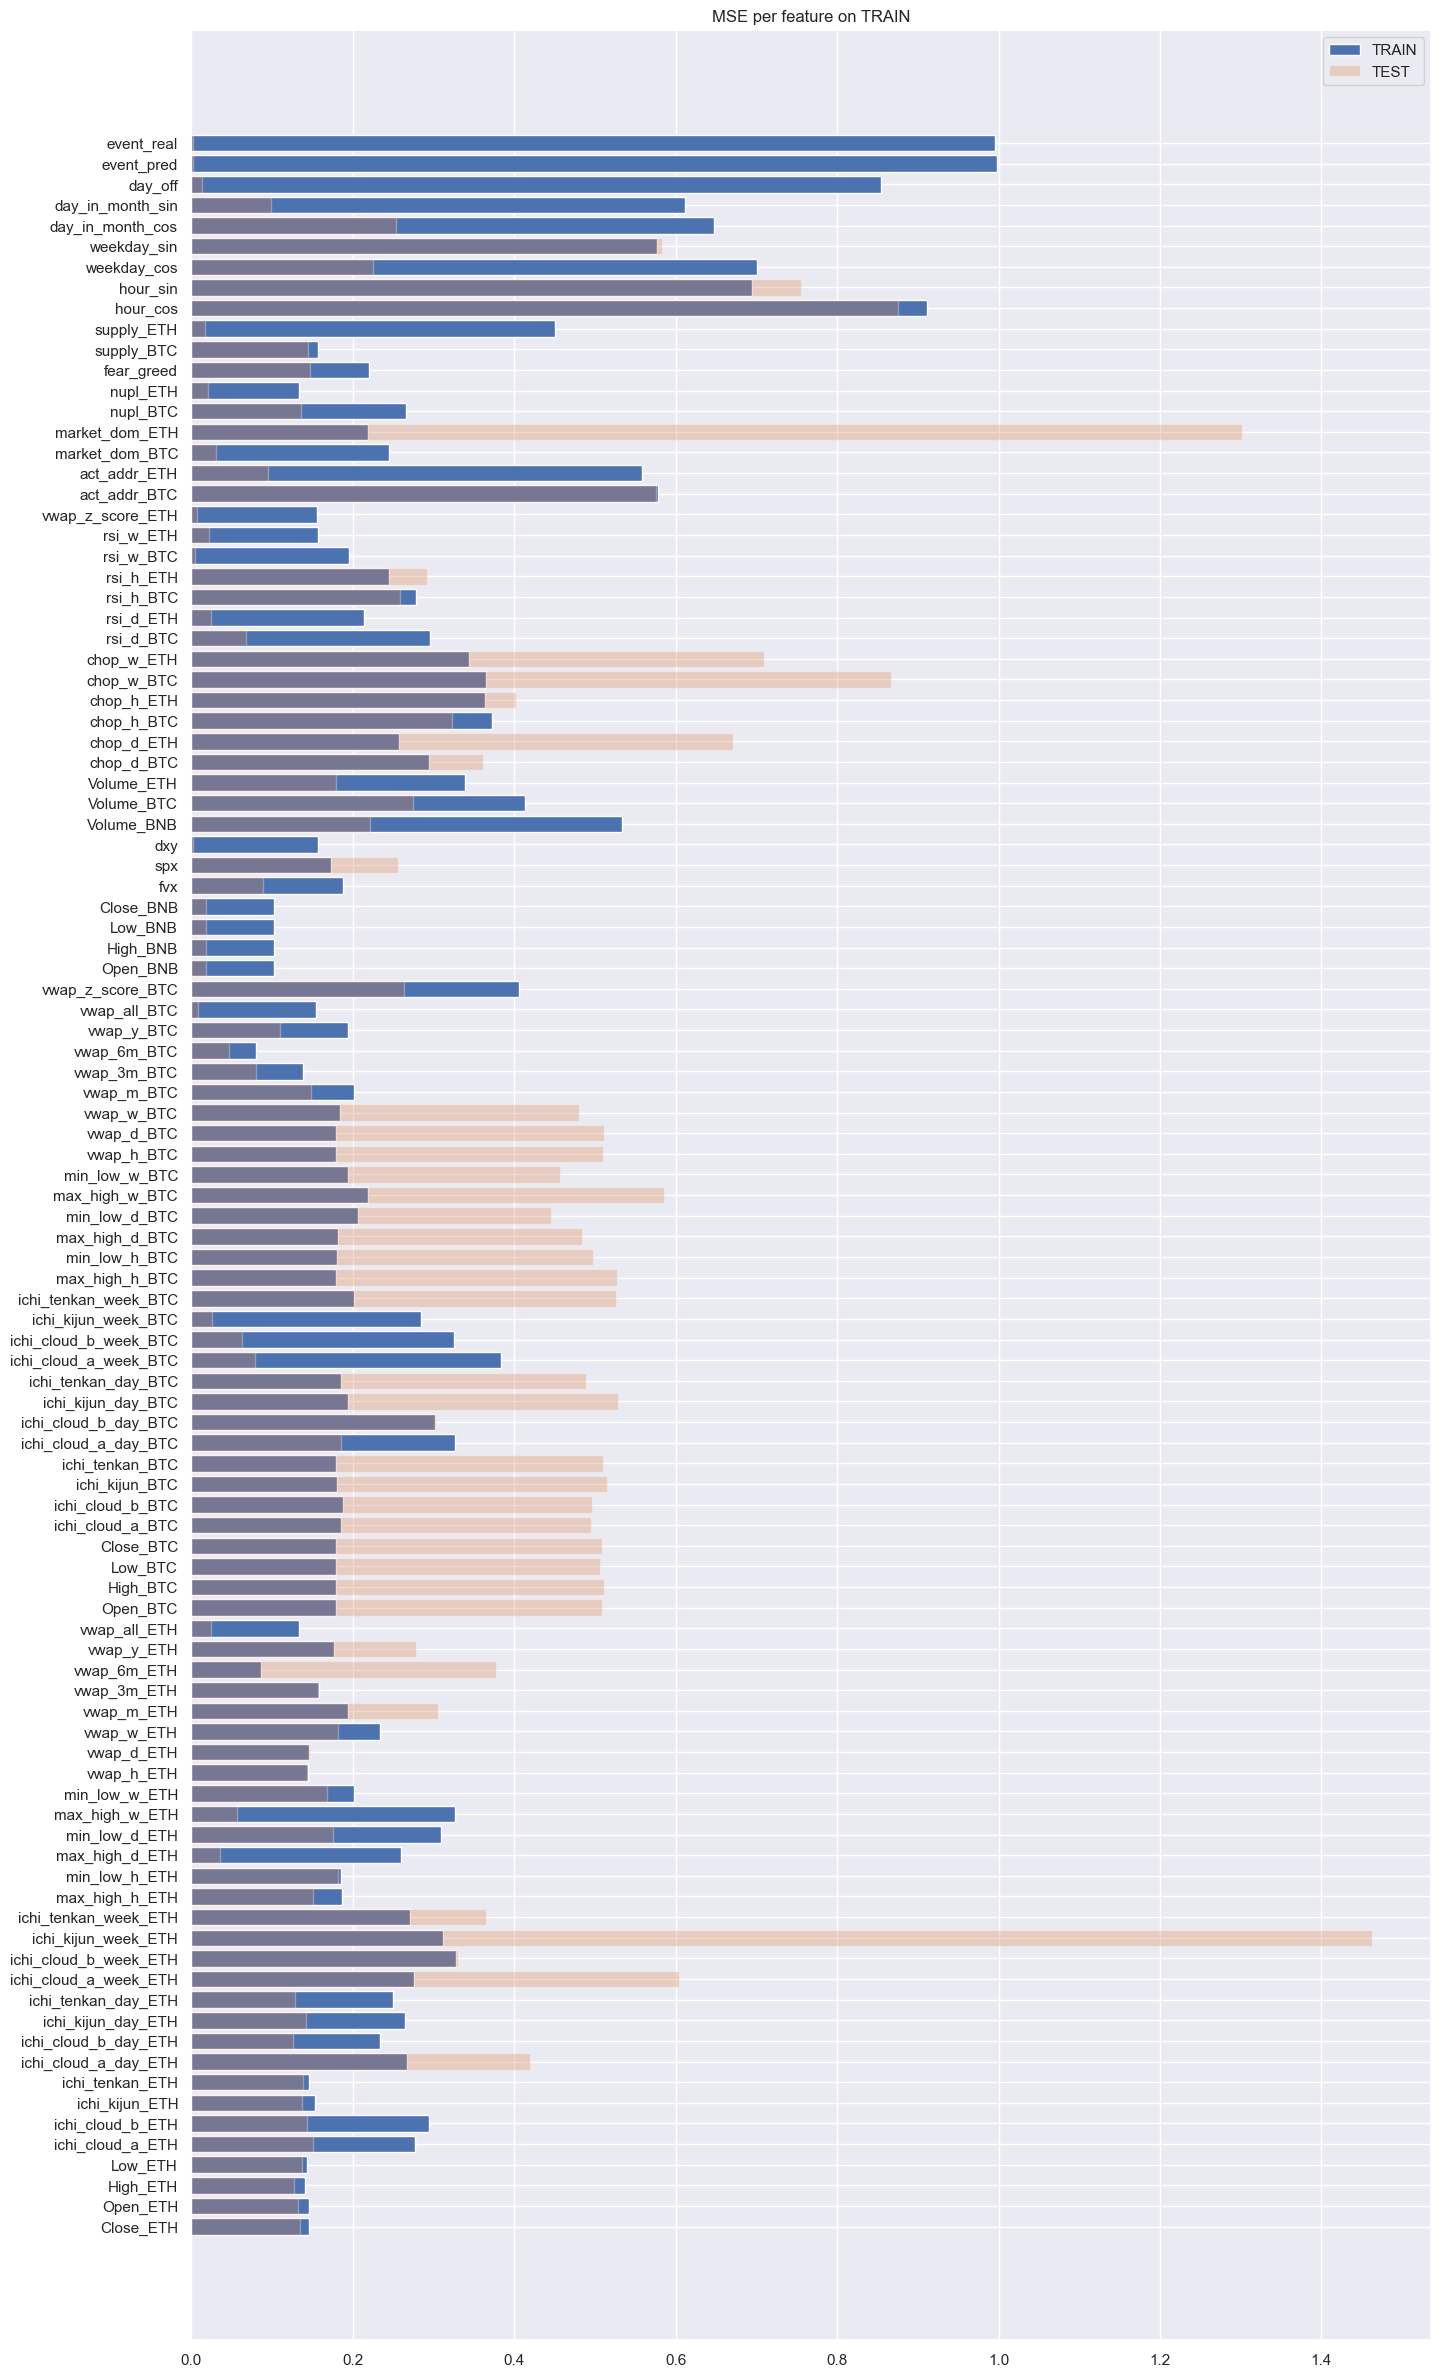

In [126]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [127]:
encoder_model.layers[3].get_weights()

[array([[ 0.02157066,  0.15477541, -0.20355693, ..., -0.31197906,
         -0.21112768, -0.14640221],
        [ 0.22923803,  0.11350423, -0.2934964 , ..., -0.29880834,
          0.2115068 ,  0.3490708 ],
        [-0.16291289,  0.11820727, -0.40679738, ..., -0.06265508,
          0.04202341, -0.20531346],
        ...,
        [ 0.49140424, -0.19211406,  0.36602134, ...,  0.67463505,
          0.5334883 , -0.2772609 ],
        [ 0.03969351,  0.3142048 , -0.21568437, ...,  0.1272518 ,
          0.019147  , -0.1114974 ],
        [ 0.16163805,  0.12065407,  0.05681299, ..., -0.0725029 ,
          0.13948293,  0.10902473]], dtype=float32),
 array([ 1.08053967e-01,  5.43437004e-02, -2.48641390e-02,  2.05133006e-01,
         8.03652331e-02, -2.24303138e-02, -3.55332375e-01,  1.30083293e-01,
        -1.41715676e-01, -1.06657505e-01,  6.64068758e-02,  1.11547932e-01,
        -1.60053987e-02, -2.26816997e-01,  1.27450272e-01, -2.16723278e-01,
        -1.51762873e-01,  2.91927271e-02, -1.87894031e

## Prediction Models

### LSTM all features

In [128]:
X_train_sca.shape

(87313, 72, 102)

In [129]:
X_train_sca.shape[-1]

102

In [130]:
X_train_sca.shape[-2:]

(72, 102)

In [131]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    PATIENCE_PRED = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=PATIENCE_PRED,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if PATIENCE_PRED == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [132]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [133]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

2729/2729 [==============================] - 30s 11ms/step


(87313, 72, 64)

In [134]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

11/11 [==============================] - 0s 22ms/step


(351, 72, 64)

In [135]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [136]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [137]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [138]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((87313, 72, 68), (351, 72, 68))

#### Correlations

In [139]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



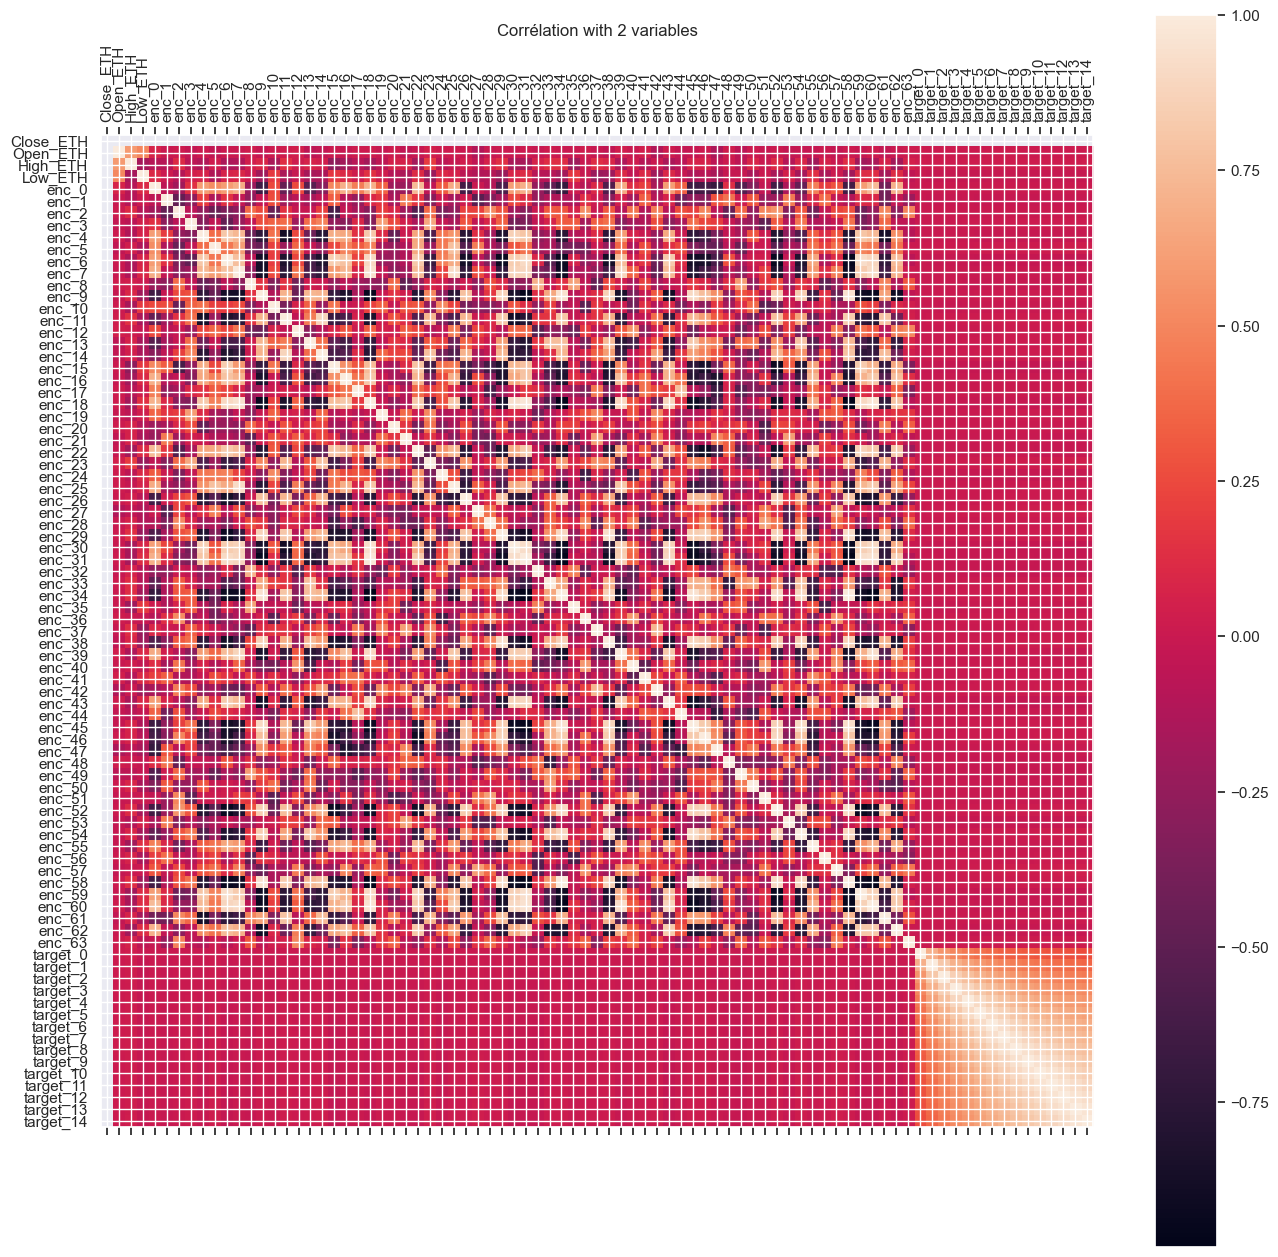

In [140]:
fig = plot_corr(corr_matrix_min)

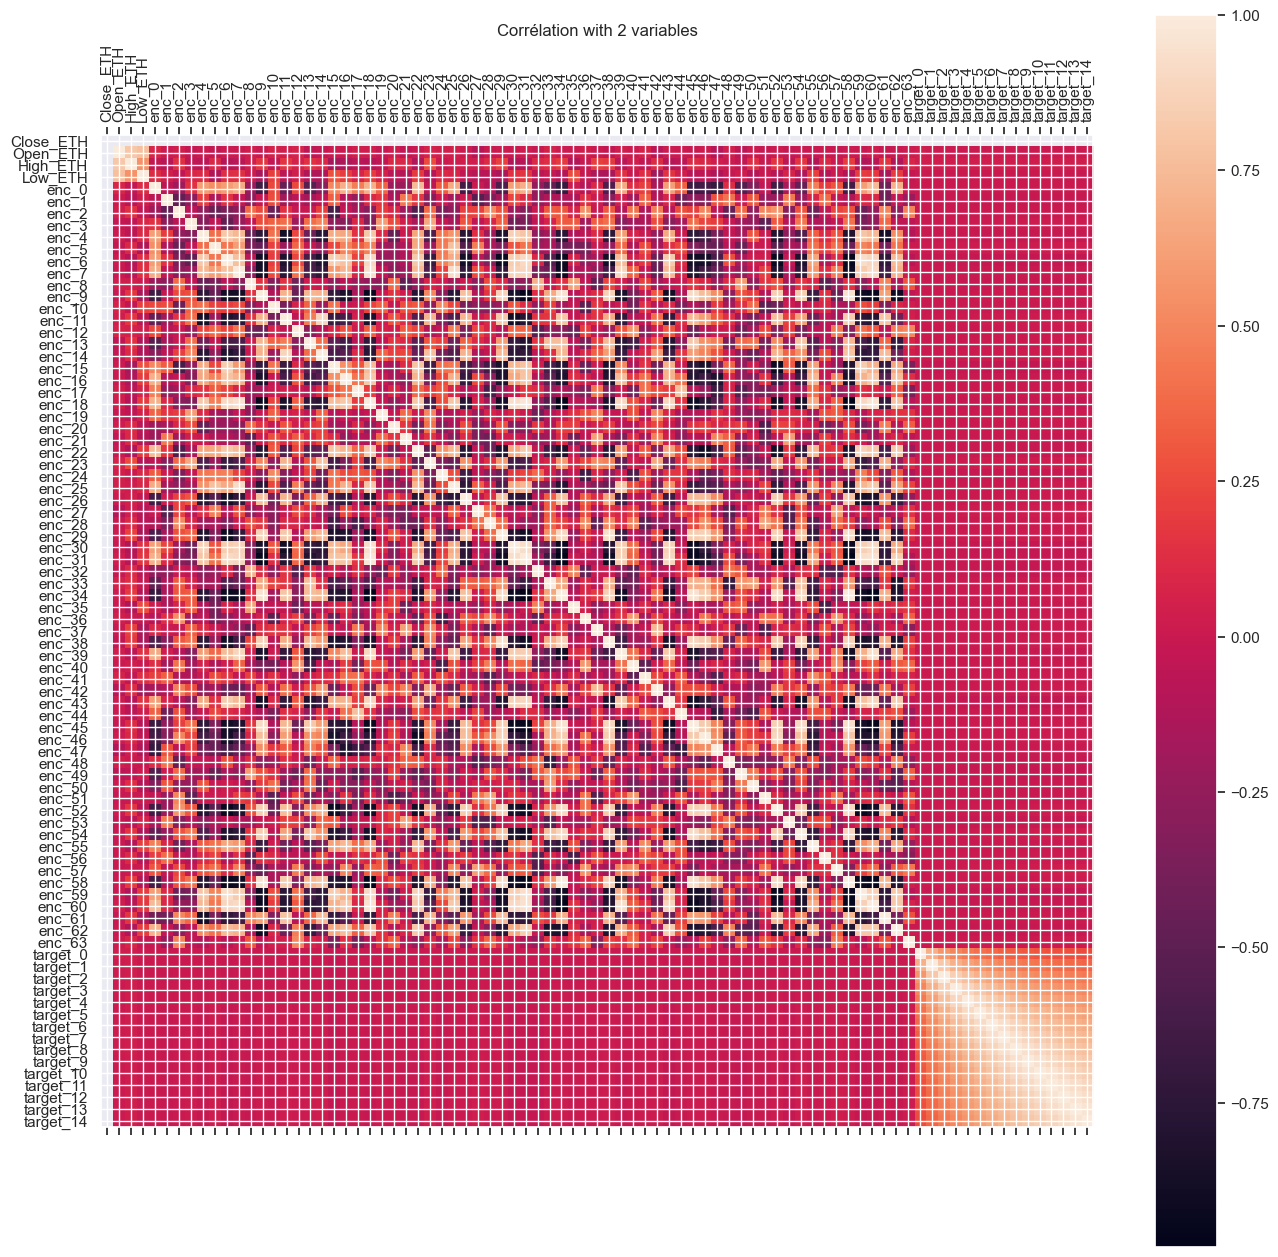

In [141]:
fig = plot_corr(corr_matrix_max) 

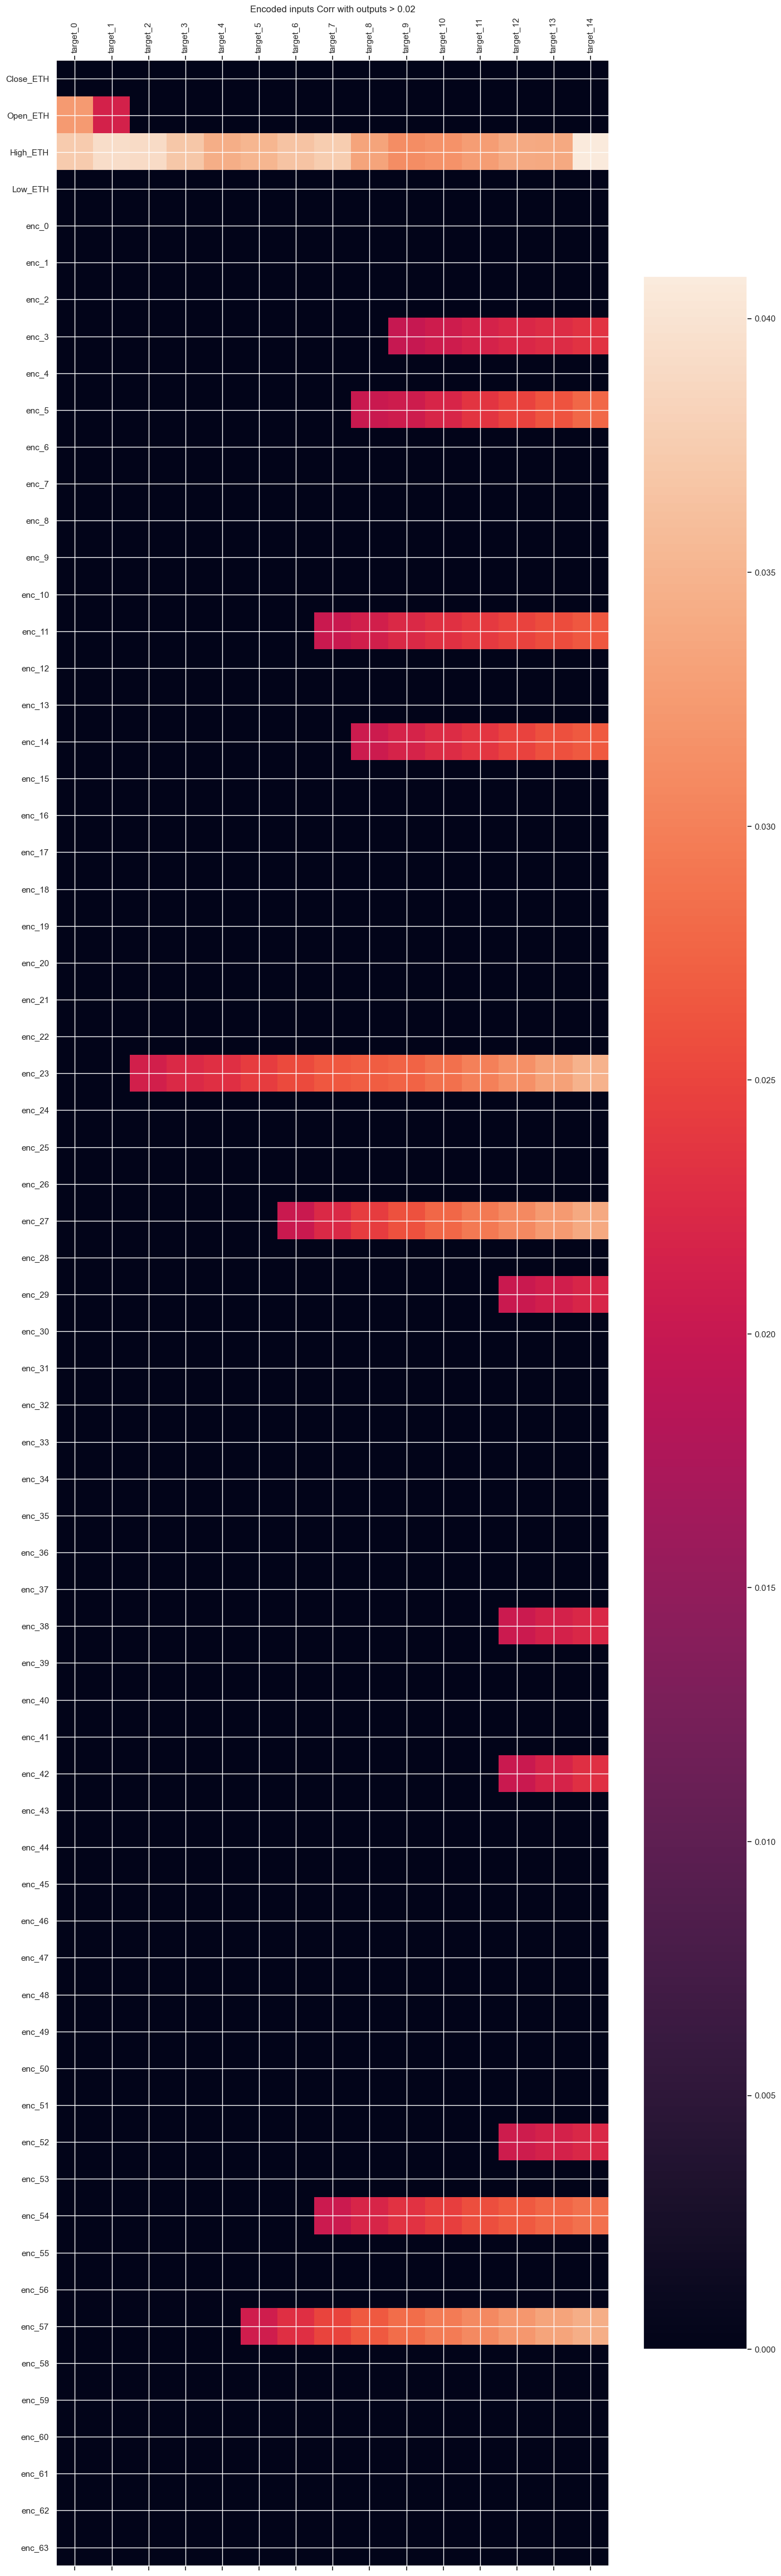

In [142]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

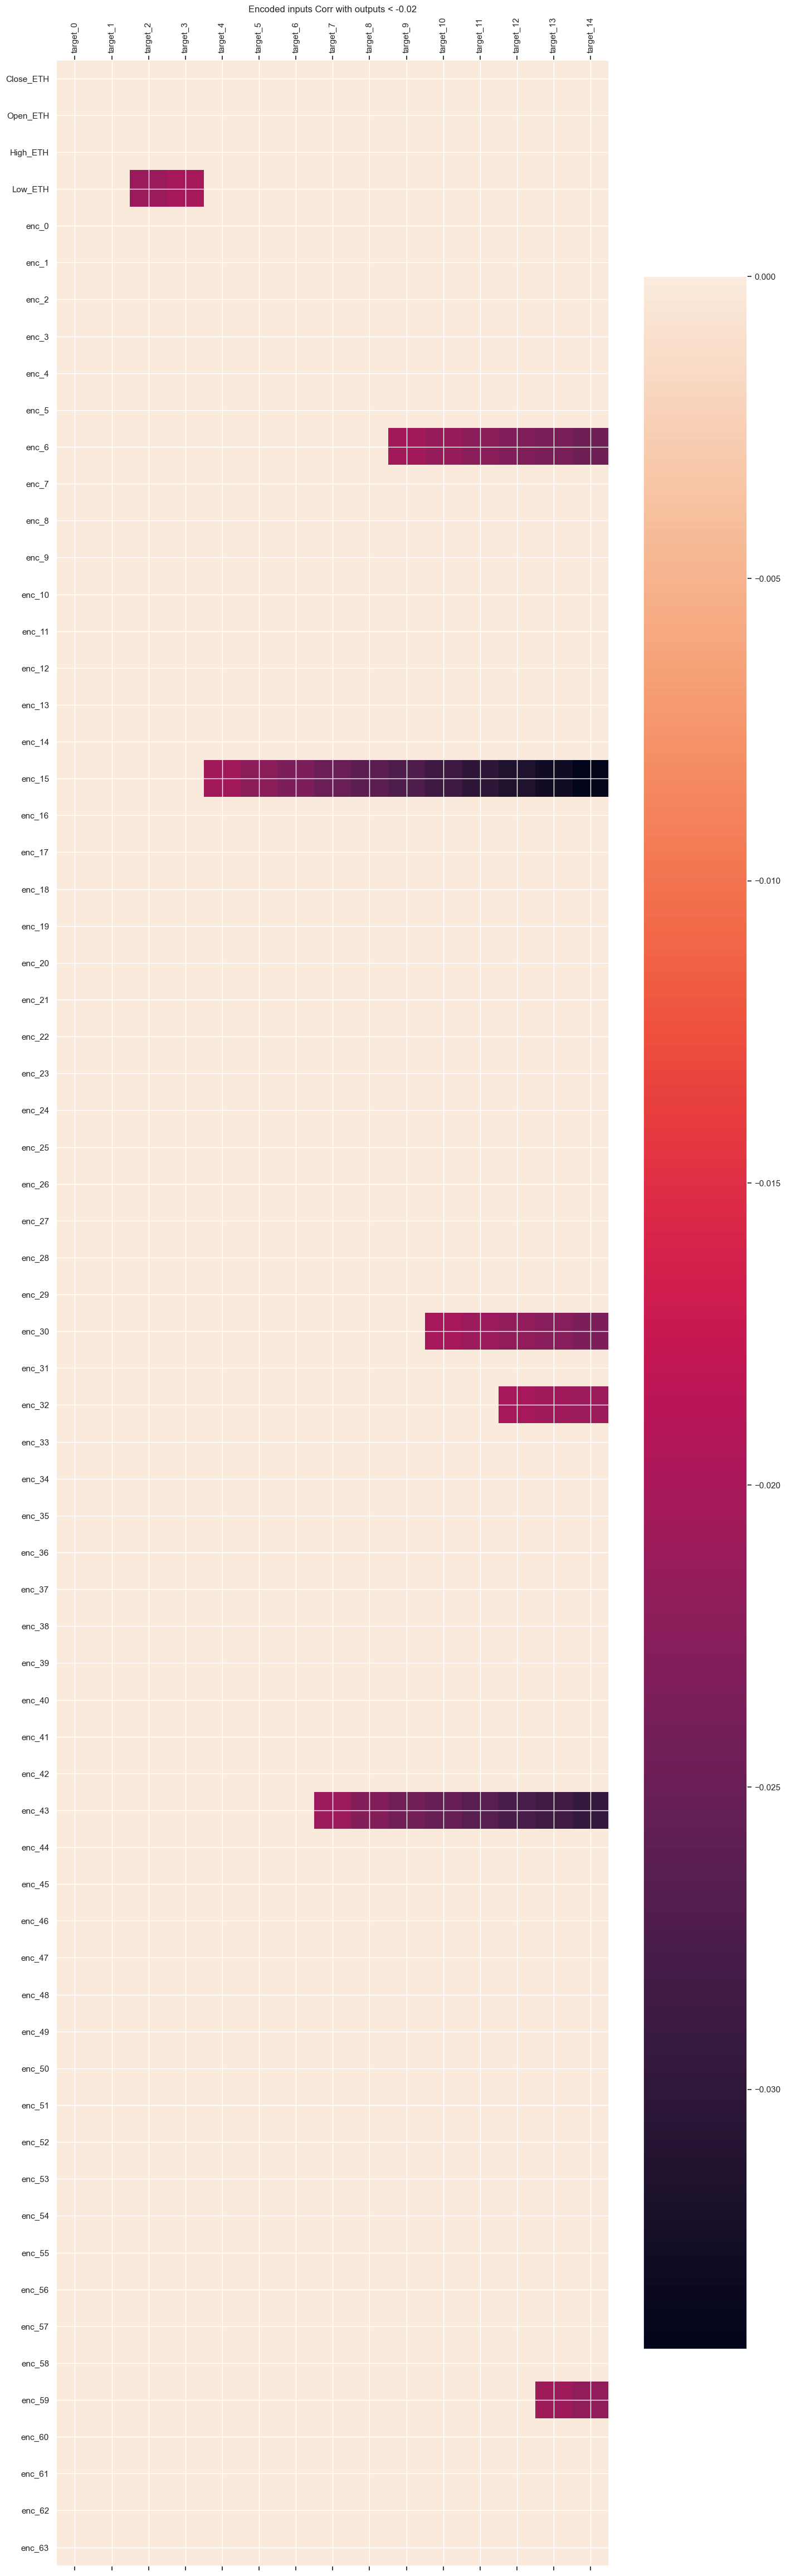

In [143]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [144]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [145]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [146]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [147]:
MODE_AUTO_SELECT

0

In [148]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
nb encoded features:  64


In [149]:
X_train_.shape

(87313, 72, 68)

In [150]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [151]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [152]:
X_train_.shape

(87313, 72, 68)

#### Train

In [153]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)

#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)

mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in LIST_UNITS_PRED: #[32, 64, 128]: #[128]: #
        for dropout_rate in  LIST_DROPOUT_PRED: #[0.05, 0.15, 0.25]: #[0.1]:
            for seed in LIST_SEEDS:
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.AdamW()
                if PATIENCE_PRED is not None:
                    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                    verbose=1, patience=PATIENCE_PRED,
                                                    restore_best_weights=True)
                # create model
                multi_step_model = tf.keras.models.Sequential()
                multi_step_model.add(
                    tf.keras.layers.LSTM(
                        n_units,
                        return_sequences=False,
                        input_shape=X_train_.shape[-2:],
                        #kernel_regularizer=reg,
                        #bias_regularizer=reg,
                    )
                )
                multi_step_model.add(tf.keras.layers.LayerNormalization())
                multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
                #multi_step_model.add(tf.keras.layers.BatchNormalization())
                multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
                # compile
                multi_step_model.compile(optimizer=optim, loss='mse')
                # fitting
                if PATIENCE_PRED == 0:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1,
                    )
                else:
                    multi_step_history = multi_step_model.fit(
                        X_train_, y_train_sca, epochs=EPOCHS_PRED,
                        batch_size=BATCH_SIZE, 
                        validation_data=(X_test_, y_test_sca), 
                        verbose=1, 
                        callbacks=[es],
                    )
                # eval
                if PATIENCE_PRED !=0:
                    # mode min val loss
                    i_epoch = np.argmin(multi_step_history.history['val_loss'])
                    mse_curr_train = multi_step_history.history['loss'][i_epoch]
                    mse_curr = multi_step_history.history['val_loss'][i_epoch]
                else:
                    # mode last
                    mse_curr_train = multi_step_history.history['loss'][-1]
                    mse_curr = multi_step_history.history['val_loss'][-1]

                print("MSE TRAIN : ", mse_curr_train)
                print("MSE TEST : ", mse_curr)
                    
                # plot MSE
                name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                plot_train_history(
                    multi_step_history,
                    f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                    saveFolder="data",
                )

                # save the best
                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate

                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_units_min = n_units
                        dropout_rate_min = dropout_rate
                        print("Save model: ", path_mdl_predict_autoenc_lstm)
                        multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

    
print("Load model: ", path_mdl_predict_autoenc_lstm)
multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
n_units = multi_step_model.layers[0].units#32
dropout_rate = multi_step_model.layers[2].rate#0.25
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               100864    
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 103055 (402.56 KB)
Trainable params: 103055 (402.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.2


In [155]:
np.min(y_train)

0.8990060972444147

In [156]:
np.max(y_train)

1.087790104524251

#### Results

##### Save mdl

In [157]:
X_train_.shape

(87313, 72, 68)

##### Predict

In [158]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

11/11 [==============================] - 0s 23ms/step


##### Plots

In [159]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(87315,)
(87315,)


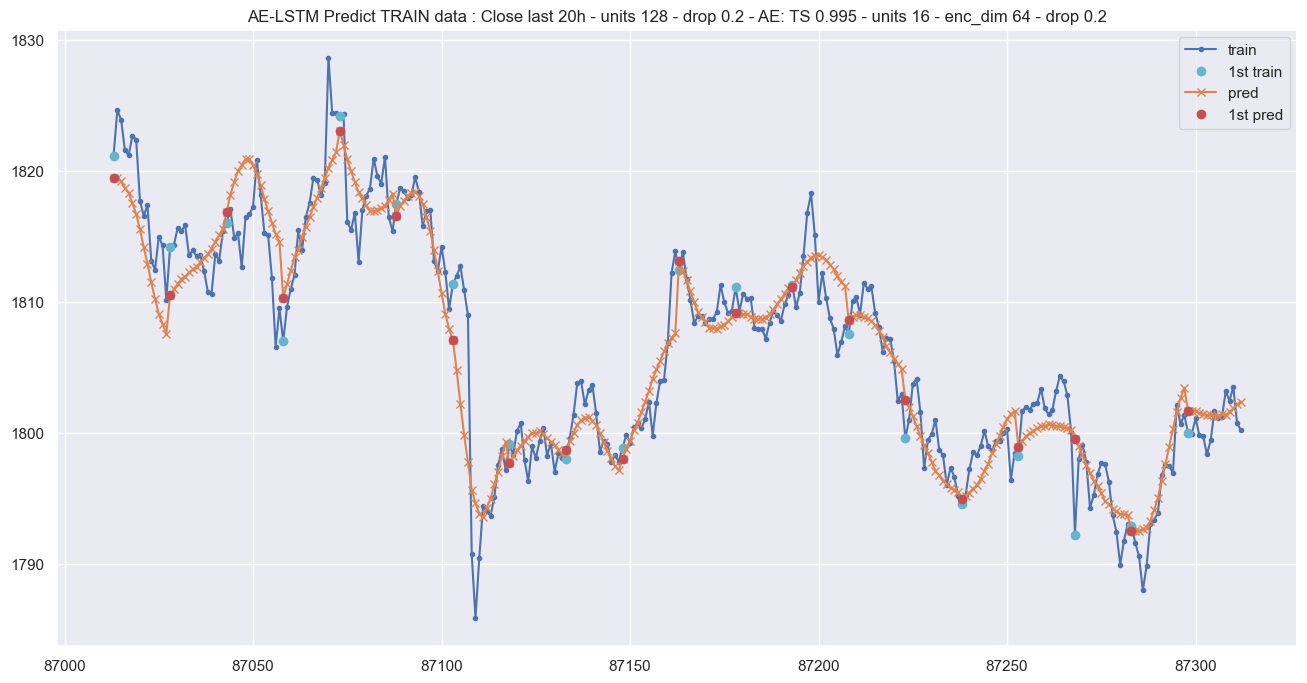

In [160]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

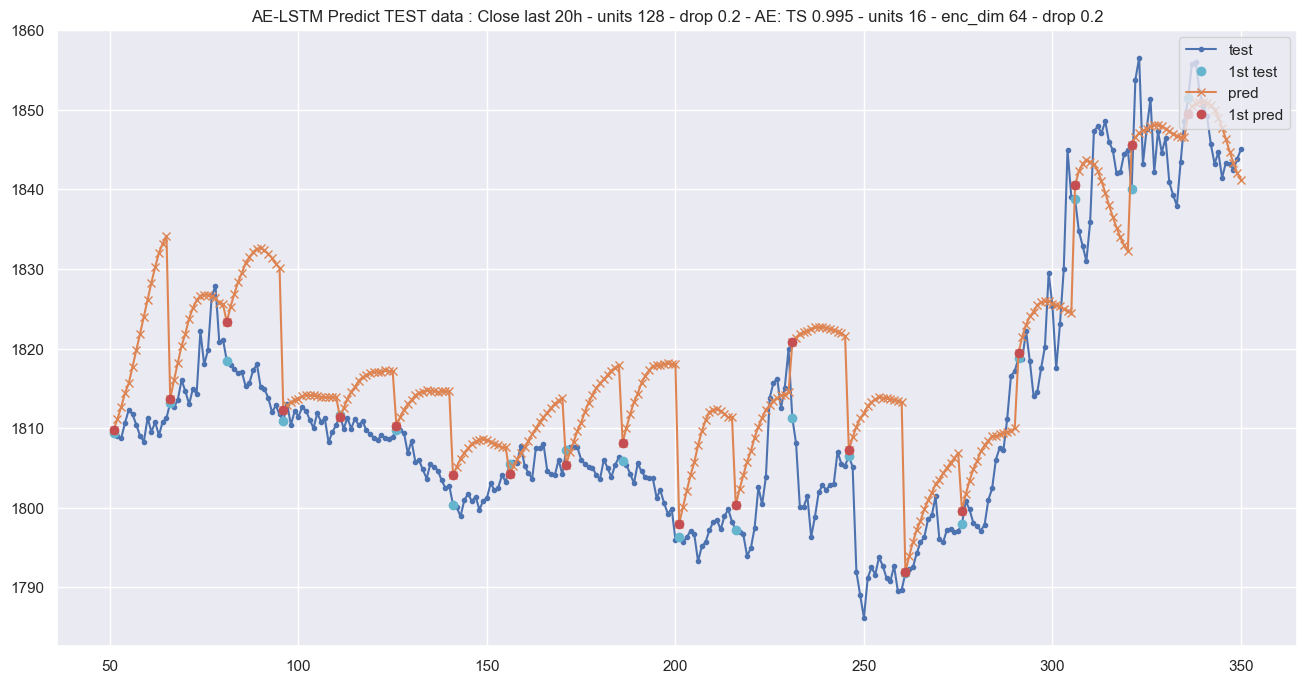

In [161]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

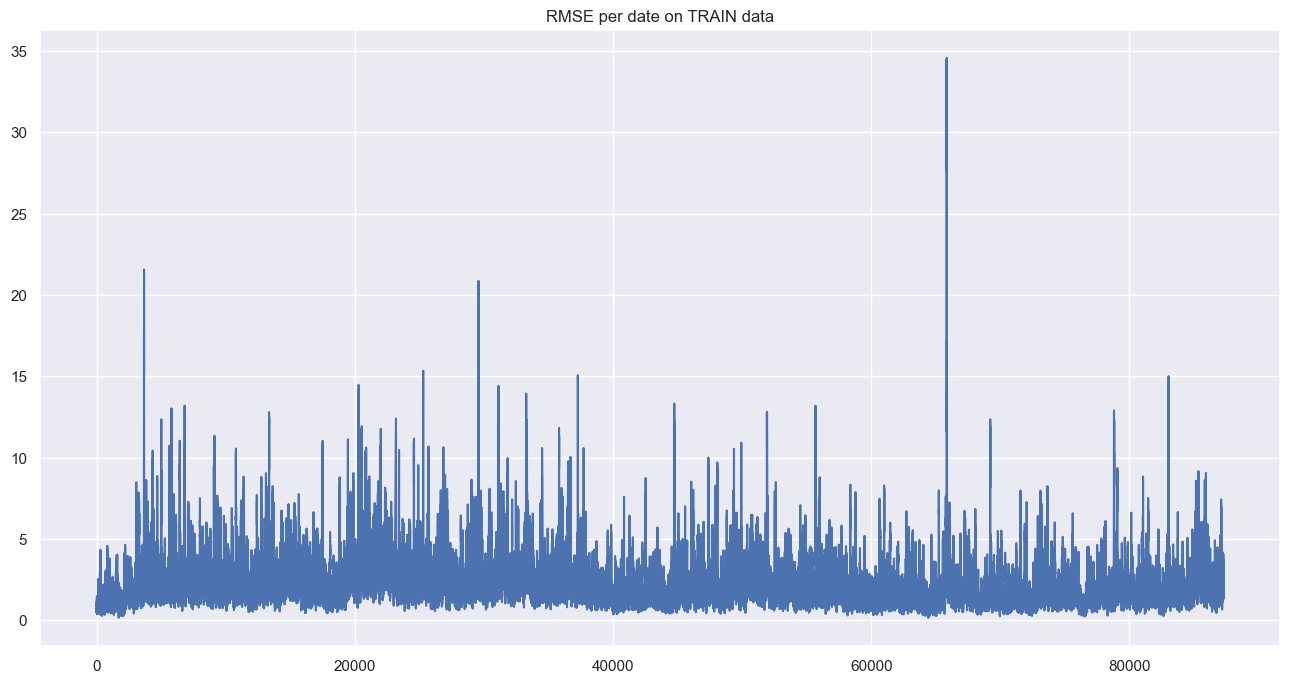

In [162]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

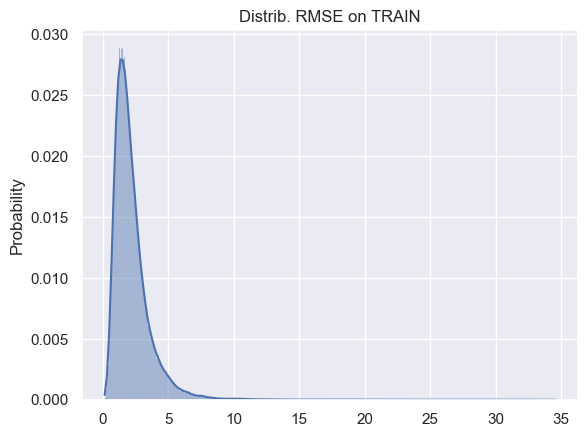

In [163]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 2.22')

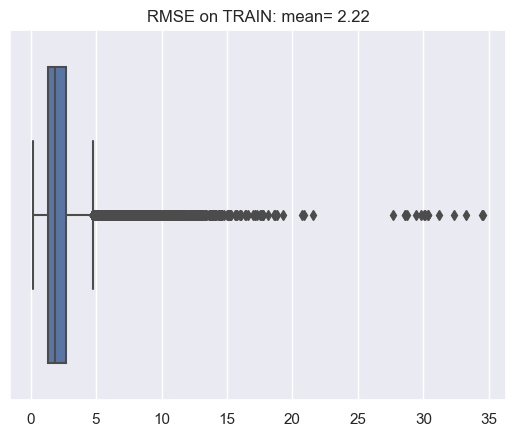

In [164]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

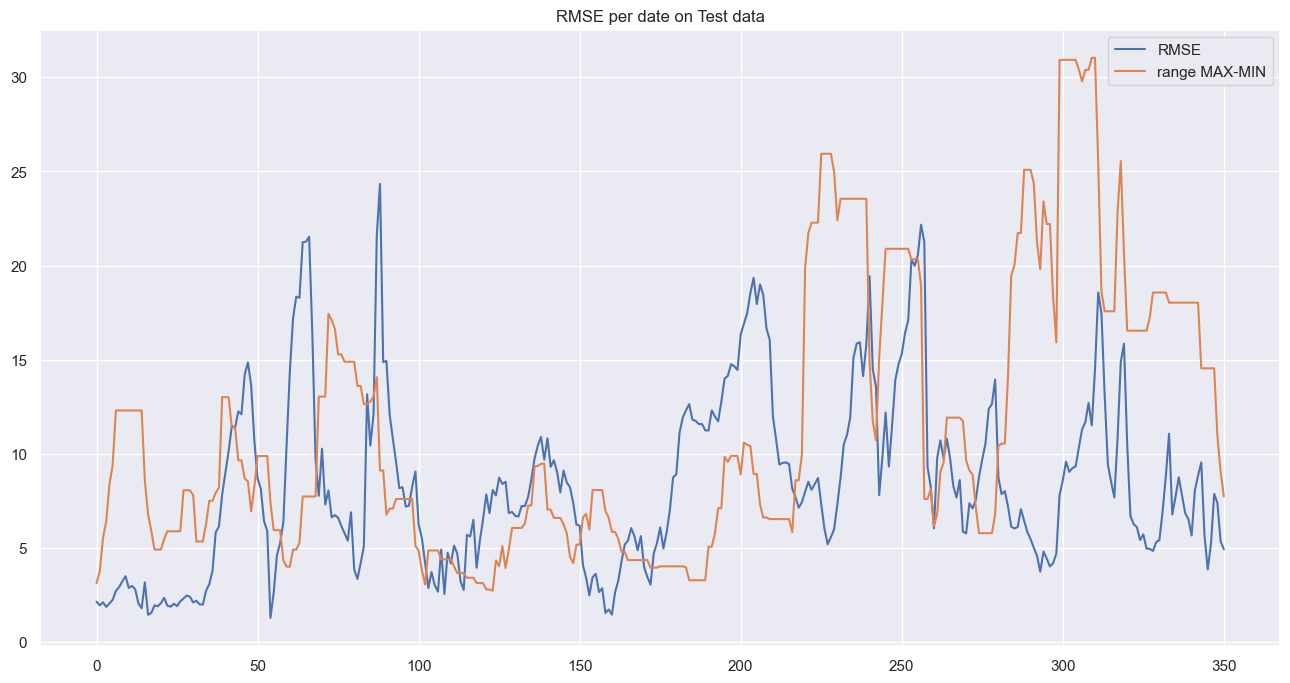

In [165]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [166]:
np.mean(arr_range)

11.437207977207965

<Axes: ylabel='Probability'>

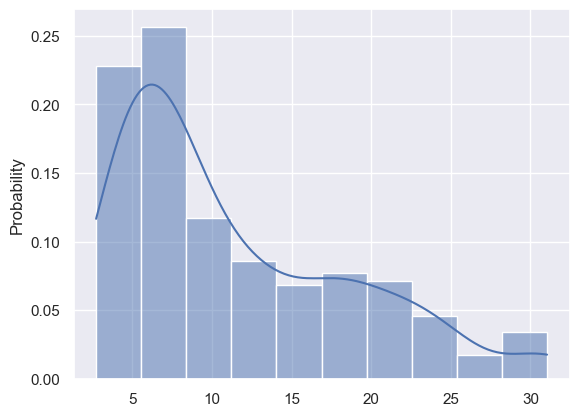

In [167]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [168]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

9.968012701114551

<Axes: ylabel='Probability'>

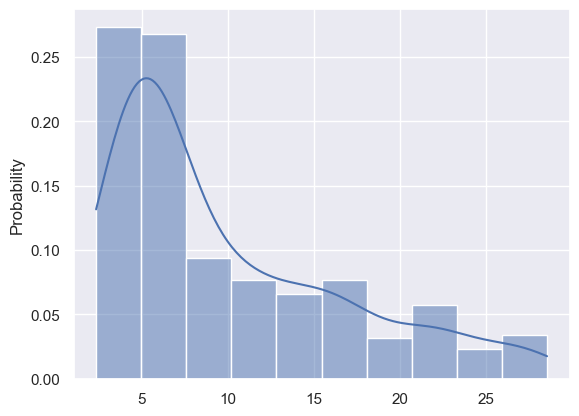

In [169]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

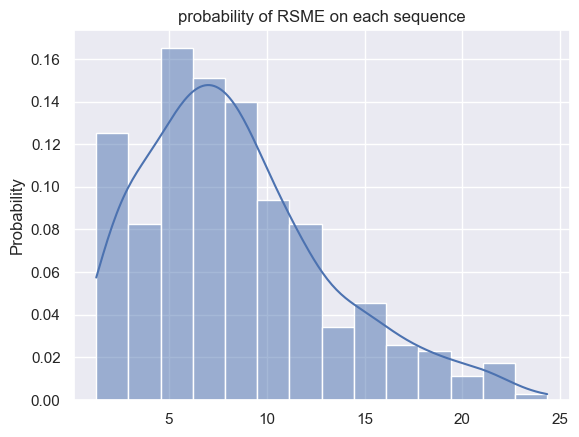

In [170]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 57.18603988603982)

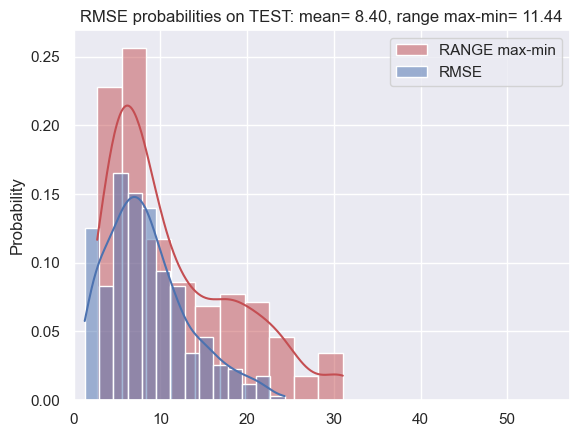

In [171]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 42.019147872271446)

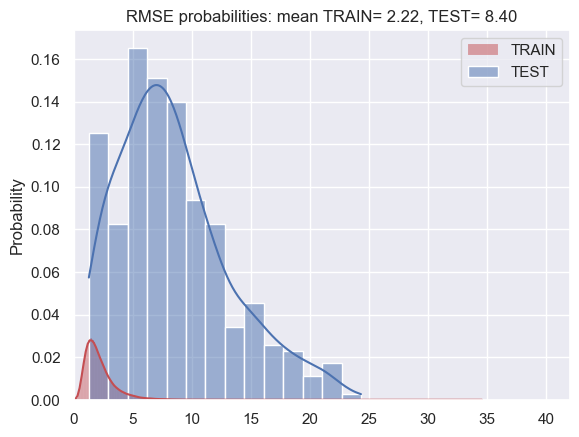

In [172]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 8.40')

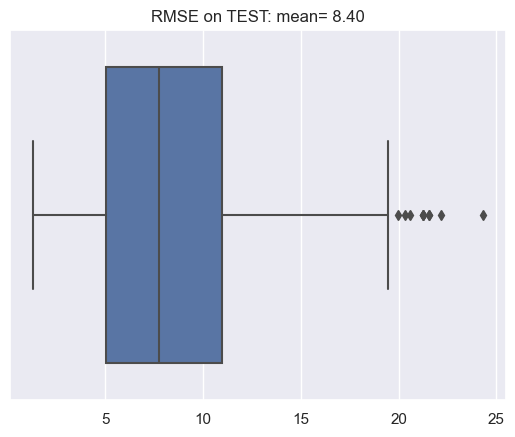

In [173]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [174]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1852.41 1850.5  1849.18 1845.7  1843.21 1844.65 1841.45 1843.36 1843.15
 1842.48 1843.8  1845.03 1845.75 1846.39 1845.32]
[1855.59097337 1855.59285401 1855.27779223 1854.92965339 1854.6300792
 1854.30207422 1853.82129525 1853.15566087 1851.97196669 1850.78163497
 1849.45412747 1848.0200875  1846.72233829 1845.63123776 1844.90232552]


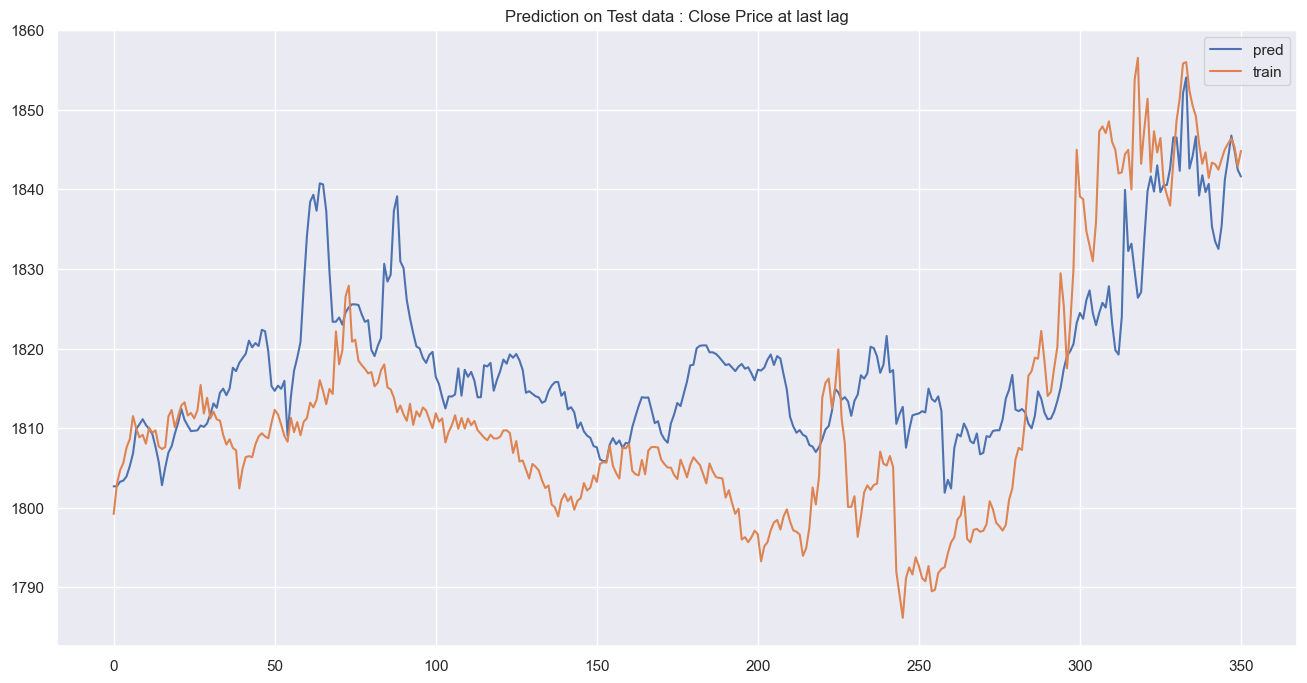

In [175]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

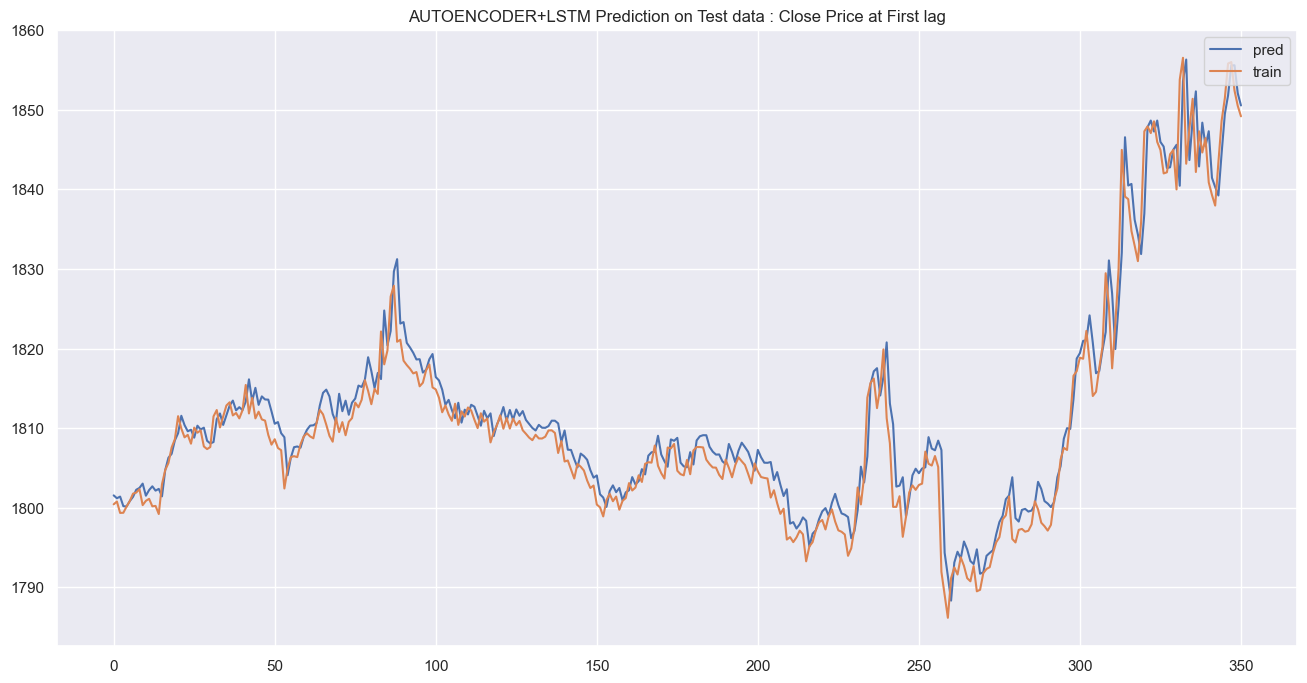

In [176]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

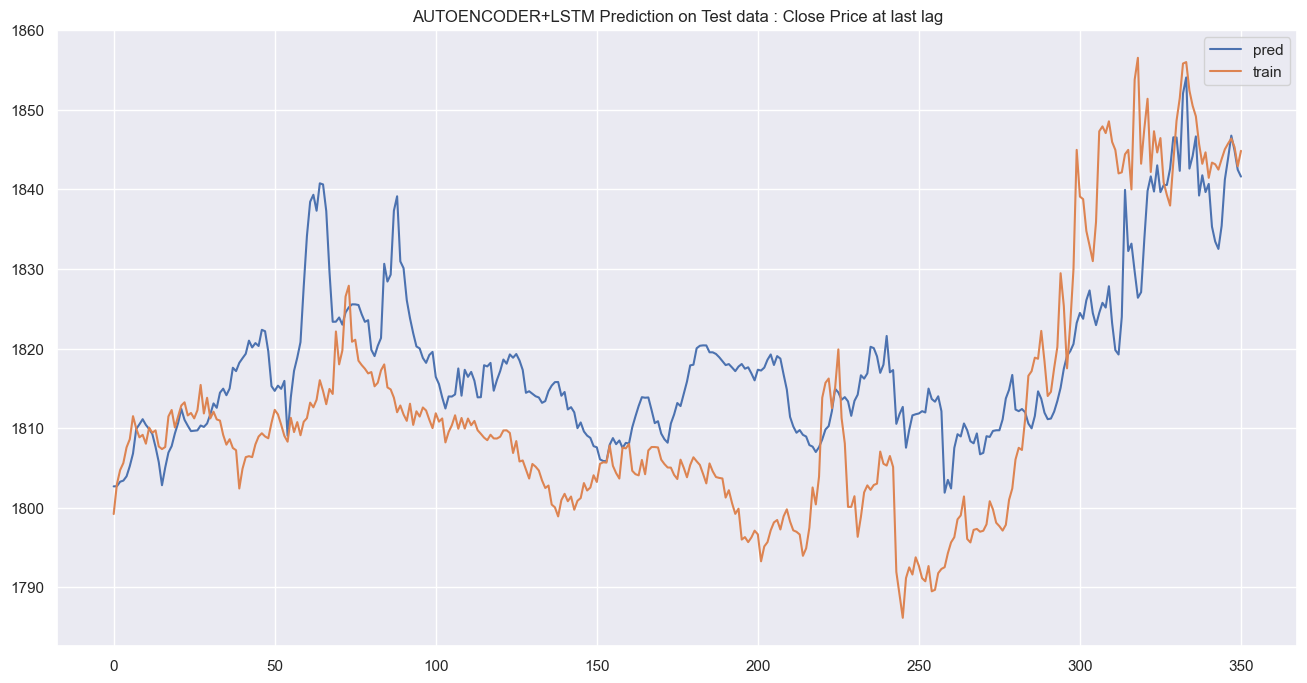

In [177]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [178]:
X_test_sca.shape

(351, 72, 102)

In [179]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [180]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [181]:
len(list_i_enc_select)

64

In [182]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1806.05 1807.52 1807.25 1811.15 1816.57 1817.15 1818.85 1818.71 1822.21
 1818.4  1814.03 1814.56 1817.54 1820.2  1829.46 1825.35 1817.51 1823.09
 1829.95 1844.96 1839.09 1838.77 1834.77 1832.92 1830.98 1835.9  1847.29
 1847.91 1847.07 1848.55 1845.96 1844.95 1842.   1842.14 1844.41 1844.96
 1839.99 1853.79 1856.53 1843.22 1847.63 1851.38 1842.18 1847.3  1844.63
 1846.44 1840.87 1839.29 1837.96 1843.42 1848.62 1851.46 1855.81 1855.99
 1852.41 1850.5  1849.18 1845.7  1843.21 1844.65 1841.45 1843.36 1843.15
 1842.48 1843.8  1845.03 1845.75 1846.39 1845.32 1842.9  1844.84 1845.18]
X_last[0,:,0] after divide by price:
[0.9787934  0.97959007 0.97944374 0.98155735 0.98449474 0.98480907
 0.98573039 0.98565452 0.98755135 0.98548651 0.98311818 0.98340541
 0.98502043 0.98646203 0.99148051 0.98925308 0.98500417 0.98802827
 0.99174606 0.99988077 0.99669951 0.99652608 0.99435827 0.99335566
 0.99230427 0.99497068 1.00114352 1.00147953 1.00102429 1.00182638
 1.0

In [183]:
X_last_encoded_sca.shape

(1, 72, 64)

In [184]:
list_i_enc_select

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

In [185]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 64)

In [186]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [187]:
X_train_.shape

(87313, 72, 68)

In [188]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
87833  1698881100000   1845.75   1848.00  1845.65    1846.39   1115.4933   
87834  1698881400000   1846.39   1846.89  1844.37    1845.32    828.6682   
87835  1698881700000   1845.31   1846.09  1841.57    1842.90   1247.9121   
87836  1698882000000   1842.91   1845.19  1841.72    1844.84   1012.7918   
87837  1698882300000   1844.83   1845.18  1844.01    1845.18    125.7257   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1727.214729       1726.792302   
1      2023-01-01 00:05:00       1727.214729       1726.792302   
2      2023-01-01 00:10:00       1727.214729       1726.792302   
3      2023-01-01 00:15:00       1727.214729       1726.792302   
4      2023-01-01 00:20:00       1727.214729       1726.792302   
...                    ...               ...               ...   
87833  2023-11-01 23:25:00       1842.800000       1826.145000   
87834  2023-11-01 23:30:00       1842.812500       1826.145000   
87835  2023-11-01 23:35:00       1844.047500       1826.145000   
87836  2023-11-01 23:40:00       1844.752500       1826.145000   
87837  2023-11-01 23:45:00       1845.090000       1826.145000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0             1194.71  ...         0.0            0.0           0.0   
1             1194.71  ...         0.0            0.0           0.0   
2             1194.71  ...         0.0            0.0           0.0   
3             1194.71  ...         0.0            0.0           0.0   
4             1194.71  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
87833         1847.06  ...         NaN            NaN           NaN   
87834         1847.06  ...         NaN            NaN           NaN   
87835         1847.06  ...         NaN            NaN           NaN   
87836         1847.06  ...         NaN            NaN           NaN   
87837         1847.06  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
87833               NaN         0.0               NaN         0.0      0.0   
87834               NaN         0.0               NaN         0.0      0.0   
87835               NaN         0.0               NaN         0.0      0.0   
87836               NaN         0.0               NaN         0.0      0.0   
87837               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
87833                  NaN  False  
87834                  NaN  False  
87835                  NaN  False  
87836                  NaN  False  
87837                  NaN  False  

[87838 rows x 136 columns]

In [189]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [190]:
y_last_pred_unscaled

array([[0.99960524, 0.999216  , 0.99877805, 0.99836564, 0.99807155,
        0.9976622 , 0.99741733, 0.9970761 , 0.99657613, 0.9961755 ,
        0.9957284 , 0.99514073, 0.9944918 , 0.9939701 , 0.99355096]],
      dtype=float32)

In [191]:
df_feat["Close_ETH"].iloc[-1]

1845.18

In [192]:
y_last_pred_raw

array([[1844.4517, 1843.7335, 1842.9253, 1842.1643, 1841.6217, 1840.8663,
        1840.4146, 1839.7849, 1838.8624, 1838.1232, 1837.2981, 1836.2139,
        1835.0165, 1834.0538, 1833.2804]], dtype=float32)

In [193]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [194]:
list_pred

[1842.1643,
 1841.6217,
 1840.8663,
 1840.4146,
 1839.7849,
 1838.8624,
 1838.1232,
 1837.2981,
 1836.2139,
 1835.0165,
 1834.0538,
 1833.2804]

In [195]:
save_list(list_pred, path_save_pred_vals)

In [196]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [197]:
list_pred_reload

[1842.1643,
 1841.6217,
 1840.8663,
 1840.4146,
 1839.7849,
 1838.8624,
 1838.1232,
 1837.2981,
 1836.2139,
 1835.0165,
 1834.0538,
 1833.2804]